# Imports

In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt
import pandas as pd

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# General functions

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern']

mpl.rcParams['font.size'] = 12

mpl.rcParams['figure.figsize'] = (10, 6)  
mpl.rcParams['axes.titlesize'] = 14   
mpl.rcParams['axes.labelsize'] = 12    
mpl.rcParams['xtick.labelsize'] = 10   
mpl.rcParams['ytick.labelsize'] = 10     
mpl.rcParams['legend.fontsize'] = 10  
mpl.rcParams['lines.linewidth'] = 1.5 
mpl.rcParams['lines.markersize'] = 6     

try:
    import seaborn as sns
    sns.set(style='whitegrid')
except ImportError:
    pass

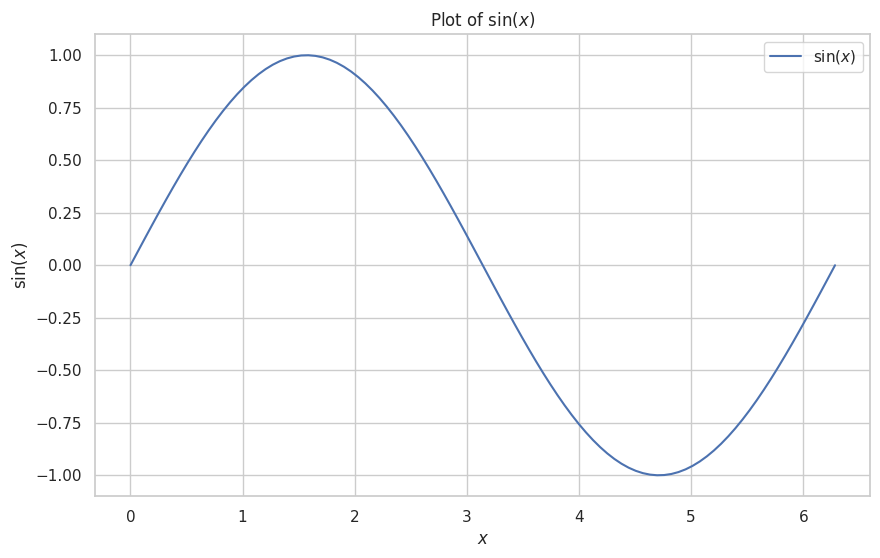

In [3]:
import numpy as np

x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)

plt.plot(x, y, label=r'$\sin(x)$')
plt.title(r'Plot of $\sin(x)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$\sin(x)$')
plt.legend()
plt.grid(True)
plt.show()

In [4]:

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

def plot_fad_scores_w_vae(df, dataset_name, reference_dataset_name, fad_model_name, plot_vae=False):
    filtered_df = df[(df['dataset'] == dataset_name) & 
                     (df['reference_dataset'] == reference_dataset_name) &
                     (df['fad_model'] == fad_model_name)]
    if filtered_df.empty:
        return
    
    resolutions = filtered_df['resolution'].unique()
    
    colors_non_vae = plt.cm.tab10(range(len(resolutions)))
    colors_vae = plt.cm.get_cmap('Pastel1')(np.arange(len(resolutions)))
    
    plt.figure(figsize=(6,4))
    
    for color, resolution in zip(colors_non_vae, resolutions):
        resolution_df = filtered_df[(filtered_df['resolution'] == resolution) &
                                    (filtered_df['vae'].isna())]
        
        resolution_df = resolution_df.sort_values(by='model_step')

        for sampler in resolution_df['sampler'].unique():
            sampler_df = resolution_df[resolution_df['sampler'] == sampler]
            line_style = '--' if sampler == 'ddim' else '-'
            marker = '+' if sampler == 'ddim' else 'o'
            markersize = 8 if sampler == 'ddim' else 4

            plt.plot(sampler_df['model_step'], sampler_df['value'], marker, markersize=markersize, label=f'{resolution} ({sampler})', linestyle=line_style, color=color)
    
    if plot_vae:
        vae_filtered_df = filtered_df[filtered_df['vae'].notna()]
        if not vae_filtered_df.empty:
            for color, resolution in zip(colors_vae, resolutions):
                resolution_vae_df = vae_filtered_df[(vae_filtered_df['resolution'] == resolution) &
                                                    (vae_filtered_df['vae'].notna())]
                
                for sampler in resolution_vae_df['sampler'].unique():
                    sampler_vae_df = resolution_vae_df[resolution_vae_df['sampler'] == sampler]
                    line_style = ':' if sampler == 'ddim' else '-.'
                    marker = 'x' if sampler == 'ddim' else 's'
                    markersize = 6 if sampler == 'ddim' else 5
                    
                    plt.plot(sampler_vae_df['model_step'], sampler_vae_df['value'], marker, markersize=markersize, label=f'{resolution} ({sampler} VAE)', linestyle=line_style, color=color)
    
    plt.title(f'Trained on {dataset_name}, Evaluated on {reference_dataset_name}')
    plt.xlabel('Model Step')
    plt.ylabel(f'FAD: {fad_model_name}')
    plt.xlim(0, 40000)
    plt.ylim(filtered_df['value'].min(), filtered_df['value'].max())
    
    plt.legend(title='Resolution (Sampler)')
    
    output_dir = '../results/plots/'
    suffix = '_w_vae' if plot_vae else ''
    os.makedirs(output_dir, exist_ok=True)
    file_name = f"fad_{dataset_name}_{reference_dataset_name}_{fad_model_name}{suffix}.png"
    plt.savefig(os.path.join(output_dir, file_name), dpi=300)
    
    plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_fad_samples(df, dataset_name):
    reference_sets = df['reference_dataset'].unique()
    fad_models = df['fad_model'].unique()

    line_styles = {'ddim': '--', 'ddpm': '-'}
    markers = {'ddim': '+', 'ddpm': 'o'}
    markersizes = {'ddim': 8, 'ddpm': 4}

    colormap = cm.get_cmap('tab10', len(df['resolution'].unique()))

    fig, axs = plt.subplots(3, 3, figsize=(18, 18))

    for i, reference_set in enumerate(reference_sets):
        for j, fad_model in enumerate(fad_models):
            ax = axs[i, j]
            filtered_df = df[(df['dataset'] == dataset_name) & 
                             (df['reference_dataset'] == reference_set) & 
                             (df['fad_model'] == fad_model)]
            filtered_df = filtered_df.sort_values(by='num_fad_samples')

            resolutions = filtered_df['resolution'].unique()
            samplers = filtered_df['sampler'].unique()
            resolution_colors = {resolution: colormap(k) for k, resolution in enumerate(resolutions)}

            for resolution in resolutions:
                for sampler in samplers:
                    sub_df = filtered_df[(filtered_df['resolution'] == resolution) & 
                                         (filtered_df['sampler'] == sampler)]
                    if not sub_df.empty:
                        line_style = line_styles.get(sampler, '-')
                        marker = markers.get(sampler, 'o')
                        markersize = markersizes.get(sampler, 4)
                        color = resolution_colors[resolution]
                        
                        ax.plot(sub_df['num_fad_samples'], sub_df['value'], 
                                linestyle=line_style, marker=marker, markersize=markersize, 
                                color=color, label=f'Resolution {resolution}, Sampler {sampler}')

            ax.set_xlabel('Number of FAD Samples')
            ax.set_ylabel('Value')
            ax.set_title(f'{reference_set}, {fad_model}')
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    plt.savefig(f"../results/plots/FAD_Samples_Grid_{dataset_name}.png", dpi=300)
    plt.show()

In [6]:
def extract_scalars(log_dir):
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    tags = event_acc.Tags()['scalars']
    data = {tag: [] for tag in tags}
    
    for tag in tags:
        scalar_events = event_acc.Scalars(tag)
        for event in scalar_events:
            data[tag].append({
                'wall_time': event.wall_time,
                'step': event.step,
                'value': event.value
            })
    return data

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_bar_graph(df, dataset, fad_model):
    filtered_df = df[(df['dataset'] == dataset) & (df['fad_model'] == fad_model)]
    
    pivot_df = filtered_df.pivot_table(values='value', 
                                       index='reference_dataset', 
                                       columns='resolution', 
                                       aggfunc='mean').fillna(0)
    
    ax = plt.gca()
    pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8), alpha=0.6, ax=ax)
    
    plt.title(f'Overlay Bar Graph for dataset={dataset} and fad_model={fad_model}')
    plt.xlabel('Reference Dataset')
    plt.ylabel('Value')
    plt.legend(title='Resolution', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_filtered_data(df, dataset, fad_model):
    filtered_df = df[(df['dataset'] == dataset) & (df['fad_model'] == fad_model)]
    fig, ax = plt.subplots()

    unique_resolutions = filtered_df['resolution'].unique()
    colors = cm.rainbow(np.linspace(0, 1, len(unique_resolutions)))
    color_dict = dict(zip(unique_resolutions, colors))

    for index, row in filtered_df.iterrows():
        if row['sampler'] == 'ddpm':
            marker = 'o'
            facecolor = color_dict[row['resolution']]
            hatch = None
        else:
            marker = 'o'
            facecolor = 'none'
            hatch = '///'
        edgecolor = color_dict[row['resolution']]
        ax.scatter(row['inference_time'], row['value'], label=row['resolution'], edgecolors=edgecolor, facecolors=facecolor, s=150, marker=marker, hatch=hatch)

    ax.set_xlabel('inference_time')
    ax.set_ylabel('value')
    
    custom_markers = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=12, label='ddpm'),
        Patch(facecolor='none', edgecolor='gray', hatch='///', label='ddim')
    ]

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    resolution_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[res], markersize=12, label=res) for res in by_label.keys()]
    combined_handles = custom_markers + resolution_handles
    combined_labels = ['ddpm', 'ddim', ''] + list(by_label.keys())

    ax.legend(combined_handles, combined_labels, title='Legend', loc='upper right')

    ax.axvline(x=1, color='gray', linestyle='--')
    ax.text(1.05, ax.get_ylim()[1] * 0.95, 'real-time inference threshold', color='gray', rotation=90, verticalalignment='top')

    plt.show()

# Load y-resolution experiments from tensorboard pythonically

In [9]:
log_dirs = ['hpc_tensorboard/models/ra_ssd_256_32/model_step_50000/samples/sch_ddpm_nisteps_1000', 
            'hpc_tensorboard/models/ra_ssd_256_64/model_step_50000/samples/sch_ddpm_nisteps_1000',
            'hpc_tensorboard/models/ra_ssd_256_128/model_step_50000/samples/sch_ddpm_nisteps_1000',
            'hpc_tensorboard/models/ra_ssd_256_256/model_step_50000/samples/sch_ddpm_nisteps_1000',
            'hpc_tensorboard/models/ra_ssd_256_512/model_step_50000/samples/sch_ddpm_nisteps_1000',
            'hpc_tensorboard/models/ra_ssd_512_32/model_step_50000/samples/sch_ddpm_nisteps_1000',
            'hpc_tensorboard/models/ra_ssd_512_64/model_step_50000/samples/sch_ddpm_nisteps_1000',
            'hpc_tensorboard/models/ra_ssd_512_128/model_step_50000/samples/sch_ddpm_nisteps_1000',
            'hpc_tensorboard/models/ra_ssd_512_256/model_step_50000/samples/sch_ddpm_nisteps_1000',
            'hpc_tensorboard/models/ra_ssd_512_512/model_step_50000/samples/sch_ddpm_nisteps_1000',
]

# new_log_dirs = []

# for log_dir in log_dirs:
#     for ms in [100, 1000, 2500, 5000, 10000, 25000]:
#         new_log_dirs.append(log_dir.replace('model_step_50000', f'model_step_{ms}'))

# log_dirs.extend(new_log_dirs)

            
log_dirs = ["../" + d for d in log_dirs]
log_dirs = [d for d in log_dirs if '/archive' not in d]
log_dirs = [d for d in log_dirs if 'audio' not in d]

In [10]:
log_dirs

['../hpc_tensorboard/models/ra_ssd_256_32/model_step_50000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ra_ssd_256_64/model_step_50000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ra_ssd_256_128/model_step_50000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ra_ssd_256_256/model_step_50000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ra_ssd_256_512/model_step_50000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ra_ssd_512_32/model_step_50000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ra_ssd_512_64/model_step_50000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ra_ssd_512_128/model_step_50000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ra_ssd_512_256/model_step_50000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ra_ssd_512_512/model_step_50000/samples/sch_ddpm_nisteps_1000']

In [11]:
all_scalars = []

for log_dir in log_dirs:
    scalars = extract_scalars(log_dir)
    for tag, values in scalars.items():
        df = pd.DataFrame(values)
        df['log_dir'] = log_dir
        df['tag'] = tag
        all_scalars.append(df)

result_df = pd.concat(all_scalars, ignore_index=True)

result_df.to_csv('y_res_scalars.csv', index=False)


2024-08-30 11:23:53.279595: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 11:23:57.964464: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
result_df

wall_time  step      value  \
0   1.724071e+09     0   0.937515   
1   1.724071e+09     0   0.871899   
2   1.724071e+09     0   6.875633   
3   1.724071e+09     0   0.945390   
4   1.724071e+09     0   1.052287   
..           ...   ...        ...   
85  1.724072e+09     0   0.831436   
86  1.724072e+09     0  10.735795   
87  1.724072e+09     0   0.681830   
88  1.724072e+09     0   0.793341   
89  1.724072e+09     0  14.834709   

                                              log_dir  \
0   ../hpc_tensorboard/models/ra_ssd_256_32/model_...   
1   ../hpc_tensorboard/models/ra_ssd_256_32/model_...   
2   ../hpc_tensorboard/models/ra_ssd_256_32/model_...   
3   ../hpc_tensorboard/models/ra_ssd_256_32/model_...   
4   ../hpc_tensorboard/models/ra_ssd_256_32/model_...   
..                                                ...   
85  ../hpc_tensorboard/models/ra_ssd_512_512/model...   
86  ../hpc_tensorboard/models/ra_ssd_512_512/model...   
87  ../hpc_tensorboard/models/ra_ssd_512_512/model...   
88  ../hpc_tensorboard/models/ra_ssd_512_512/model...   
89  ../hpc_tensorboard/models/ra_ssd_512_512/model...   

                                                  tag  
0   fad_clap-laion-audio_ref_spotify_sleep_dataset...  
1   fad_clap-laion-music_ref_spotify_sleep_dataset...  
2       fad_vggish_ref_spotify_sleep_dataset_gen_None  
3           fad_clap-laion-audio_ref_fma_pop_gen_None  
4           fad_clap-laion-music_ref_fma_pop_gen_None  
..                                                ...  
85          fad_clap-laion-music_ref_fma_pop_gen_None  
86                    fad_vggish_ref_fma_pop_gen_None  
87        fad_clap-laion-audio_ref_musiccaps_gen_None  
88        fad_clap-laion-music_ref_musiccaps_gen_None  
89                  fad_vggish_ref_musiccaps_gen_None  

[90 rows x 5 columns]

In [13]:
def extract_dataset(log_dir):
    return log_dir.split('/')[3].split('_')[1]

def extract_resolution(log_dir):
    return ','.join(log_dir.split('/')[3].split('_')[1:])

def extract_model_step(log_dir):
    return int(log_dir.split('/')[4].split('_')[2])

def extract_sampler(log_dir):
    return log_dir.split('/')[-1].split('_')[1]

result_df['dataset'] = result_df['log_dir'].apply(extract_dataset)
result_df['resolution'] = result_df['log_dir'].apply(extract_resolution)
result_df['model_step'] = result_df['log_dir'].apply(extract_model_step)
result_df['sampler'] = result_df['log_dir'].apply(extract_sampler)

def extract_fad_model(tag):
    return tag.split('fad_')[1].split('_ref')[0]

def extract_reference_dataset(tag):
    return tag.split('_ref_')[1].split('_gen')[0]

result_df['fad_model'] = result_df['tag'].apply(extract_fad_model)
result_df['reference_dataset'] = result_df['tag'].apply(extract_reference_dataset)

result_df.drop(columns=['log_dir', 'tag'], inplace=True)

In [14]:
result_df['resolution'] = result_df['resolution'].apply(lambda x: x[4:])

In [15]:
result_df

wall_time  step      value dataset resolution  model_step sampler  \
0   1.724071e+09     0   0.937515     ssd     256,32       50000    ddpm   
1   1.724071e+09     0   0.871899     ssd     256,32       50000    ddpm   
2   1.724071e+09     0   6.875633     ssd     256,32       50000    ddpm   
3   1.724071e+09     0   0.945390     ssd     256,32       50000    ddpm   
4   1.724071e+09     0   1.052287     ssd     256,32       50000    ddpm   
..           ...   ...        ...     ...        ...         ...     ...   
85  1.724072e+09     0   0.831436     ssd    512,512       50000    ddpm   
86  1.724072e+09     0  10.735795     ssd    512,512       50000    ddpm   
87  1.724072e+09     0   0.681830     ssd    512,512       50000    ddpm   
88  1.724072e+09     0   0.793341     ssd    512,512       50000    ddpm   
89  1.724072e+09     0  14.834709     ssd    512,512       50000    ddpm   

           fad_model      reference_dataset  
0   clap-laion-audio  spotify_sleep_dataset  
1   clap-laion-music  spotify_sleep_dataset  
2             vggish  spotify_sleep_dataset  
3   clap-laion-audio                fma_pop  
4   clap-laion-music                fma_pop  
..               ...                    ...  
85  clap-laion-music                fma_pop  
86            vggish                fma_pop  
87  clap-laion-audio              musiccaps  
88  clap-laion-music              musiccaps  
89            vggish              musiccaps  

[90 rows x 9 columns]

In [33]:
import matplotlib.pyplot as plt

# Customize the axes and gridlines
sns.set_style("whitegrid", {
    'axes.edgecolor': '0',
    'axes.linewidth': 1.25,
    'grid.color': '.8',
    'grid.linestyle': '--'
})


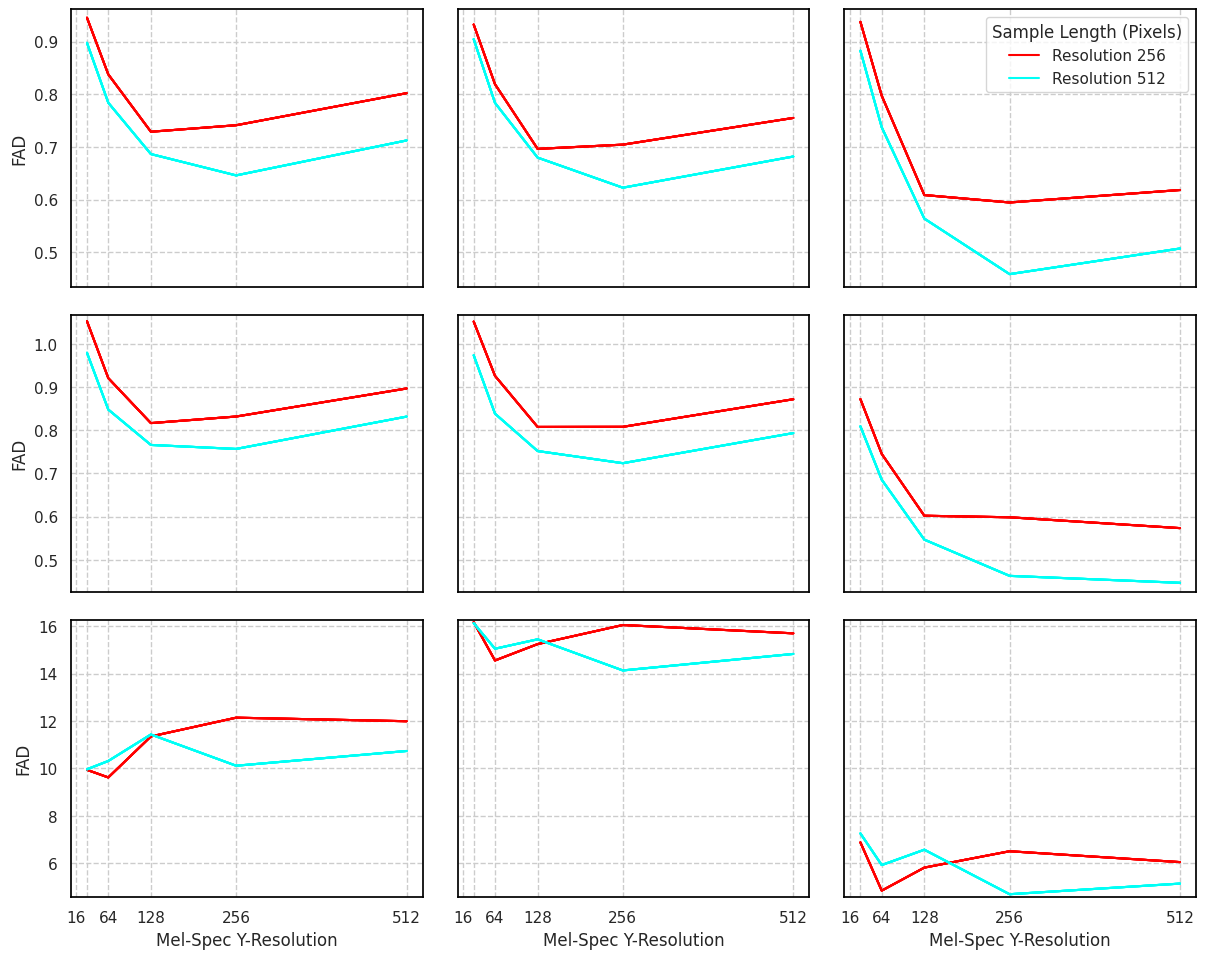

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_filtered_data(ax, result_df, dataset, model_step, fad_model, reference_dataset, hue_dict, labels_plotted):
    # Filter the dataframe based on the provided parameters
    filtered_df = result_df[
        (result_df['dataset'] == dataset) &
        (result_df['model_step'] == model_step) &
        (result_df['fad_model'] == fad_model) &
        (result_df['reference_dataset'] == reference_dataset)
    ]
    # Extract the unique resolution values
    resolution_values = filtered_df['resolution'].unique()
    
    for resolution in resolution_values:
        # Split the resolution into two values
        resolution_hue, resolution_x = resolution.split(',')
        resolution_hue = int(resolution_hue.strip())
        resolution_x = int(resolution_x.strip())

        # Assign a hue color for each unique resolution_hue
        if resolution_hue not in hue_dict:
            hue_dict[resolution_hue] = len(hue_dict)
        
        # Filter the dataframe for the current resolution_hue
        subset = filtered_df[filtered_df['resolution'].str.startswith(str(resolution_hue))]
        
        # Determine the label for the plot
        label = f'Resolution {resolution_hue}'
        
        # Plot the data
        ax.plot(subset['resolution'].str.split(',').str[1].astype(int), subset['value'], 
                label=label if label not in labels_plotted else "", 
                color=plt.cm.hsv(hue_dict[resolution_hue] / len(hue_dict)))
        
        labels_plotted.add(label)  # Mark this label as plotted

# Create a 3x3 grid of plots with additional space for labels
fig, axs = plt.subplots(3, 3, figsize=(15, 12))

# Dictionary to hold hues for each first part of resolution
hue_dict = {}
labels_plotted = set()

# Loop over fad_model and reference_dataset to populate the grid
for i, fad_model in enumerate(['clap-laion-audio', 'clap-laion-music', 'vggish']):
    for j, reference_dataset in enumerate(['fma_pop', 'musiccaps', 'spotify_sleep_dataset']):
        # Plot the data on the corresponding subplot
        plot_filtered_data(axs[i, j], result_df, 'ssd', 50000, fad_model, reference_dataset, hue_dict, labels_plotted)
        
        # Set x-axis ticks and labels to specific values
        axs[i, j].set_xticks([16, 32, 64, 128, 256, 512])
        axs[i, j].set_xticklabels([16, '', 64, 128, 256, 512])  # Empty string for 32
        
        # Label the x-axis for the bottom-most plots
        if i == 2:
            axs[i, j].set_xlabel('Mel-Spec Y-Resolution')
        
        # Label the y-axis for the left-most plots
        if j == 0:
            axs[i, j].set_ylabel('FAD')
        
        # Remove x and y ticks for non-edge plots
        if i < 2:
            axs[i, j].set_xticklabels([])
        if j > 0:
            axs[i, j].set_yticklabels([])

# Synchronize y-axis scales across rows
for i in range(3):
    ymin = min(ax.get_ylim()[0] for ax in axs[i, :])
    ymax = max(ax.get_ylim()[1] for ax in axs[i, :])
    for ax in axs[i, :]:
        ax.set_ylim(ymin, ymax)

# Create a single legend for the entire figure
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title='Sample Length (Pixels)', bbox_to_anchor=(0.9, 0.85))

# Adjust layout to avoid overlapping
plt.subplots_adjust(left=0.15, top=0.85, wspace=0.1, hspace=0.1)

# Show the full plot grid
plt.savefig('y_resolution.png', dpi=300, bbox_inches='tight')
plt.show()


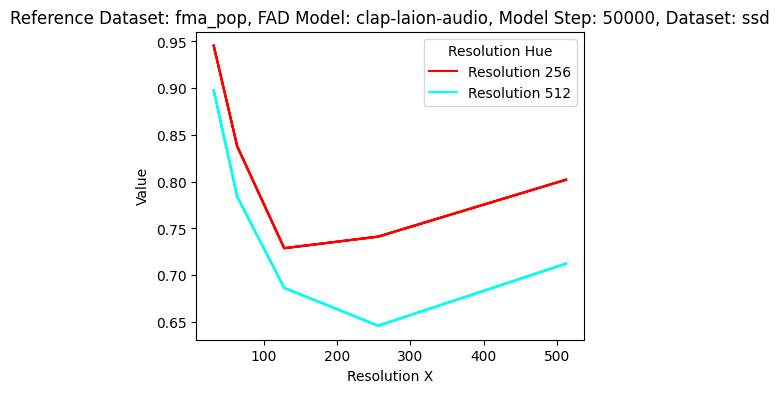

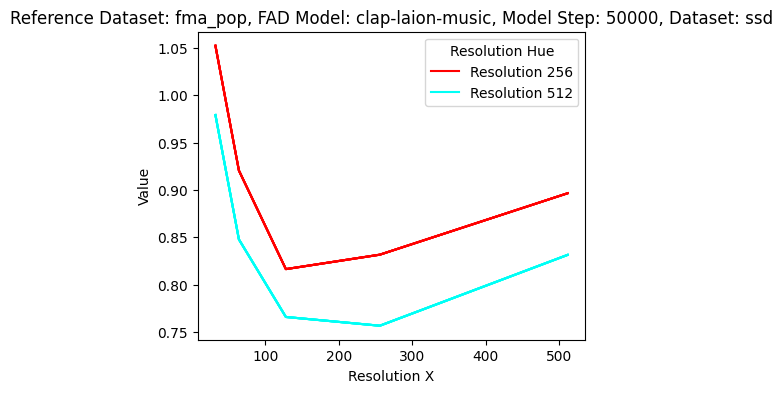

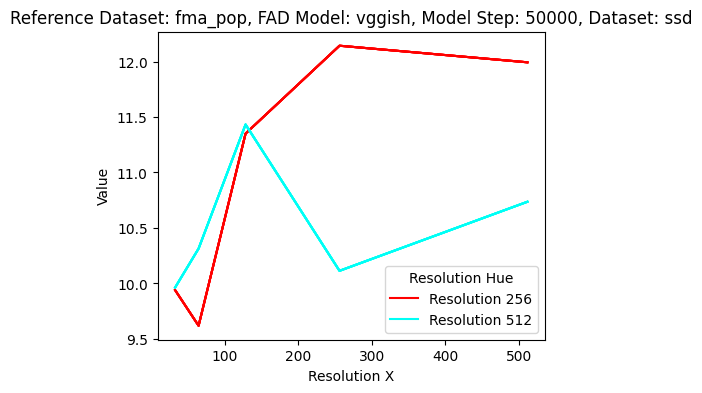

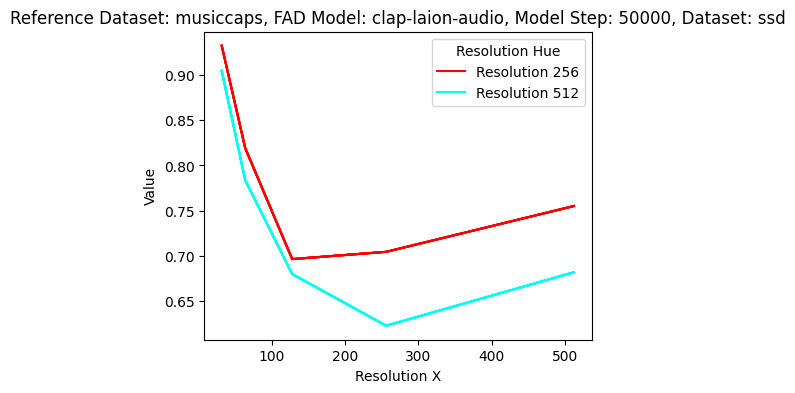

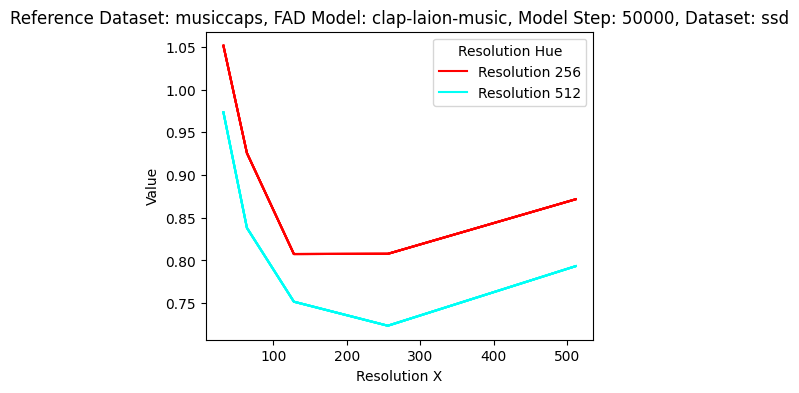

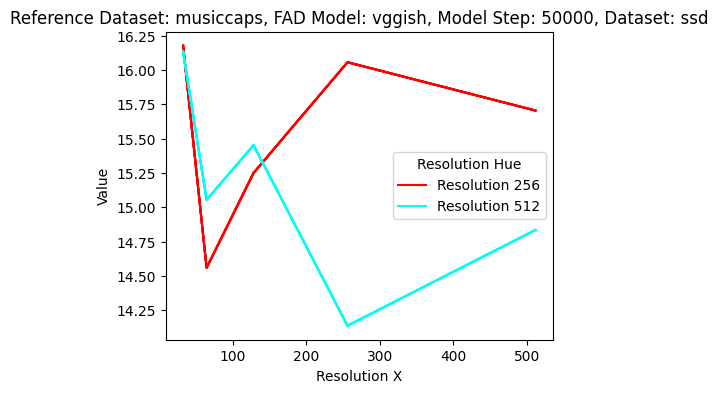

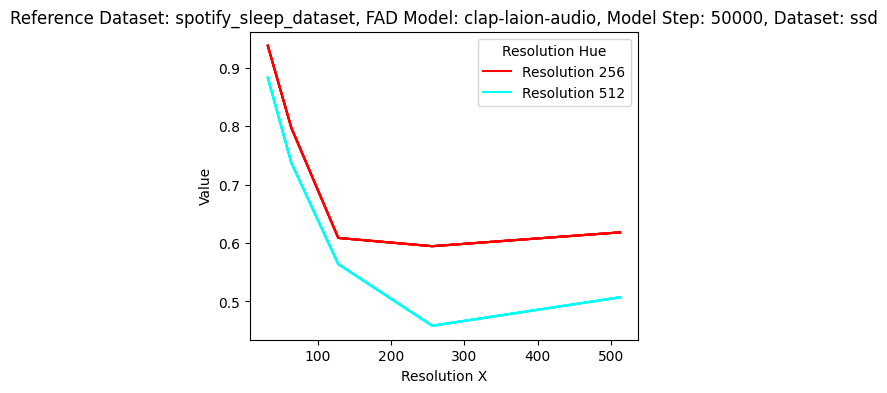

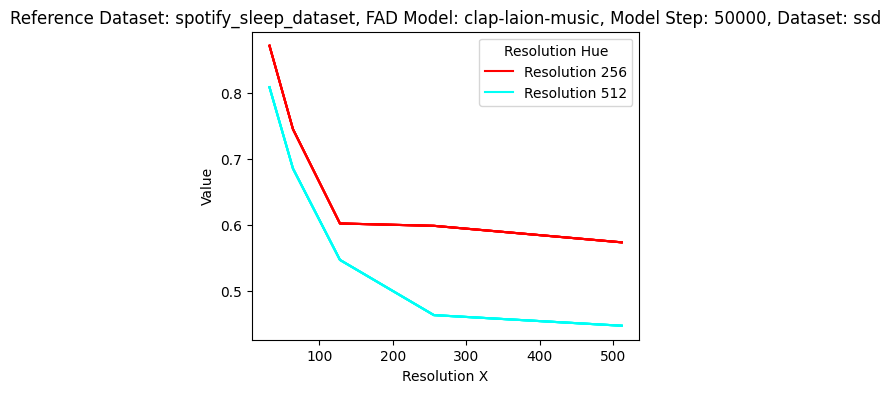

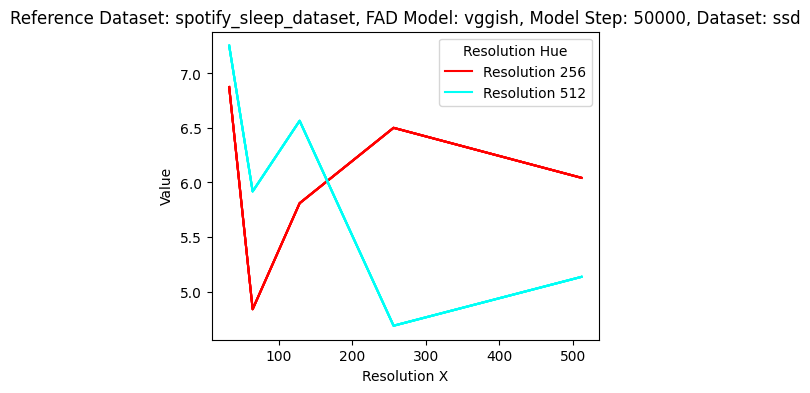

In [22]:
for reference_dataset in ['fma_pop', 'musiccaps', 'spotify_sleep_dataset']:
    for fad_model in ['clap-laion-audio', 'clap-laion-music', 'vggish']:
        plot_filtered_data(result_df, 'ssd', 50000, fad_model, reference_dataset)

wall_time  step      value dataset resolution  model_step sampler  \
8   1.724071e+09     0  16.176693     ssd     256,32       50000    ddpm   
17  1.724071e+09     0  14.559121     ssd     256,64       50000    ddpm   
26  1.724071e+09     0  15.249970     ssd    256,128       50000    ddpm   
35  1.724071e+09     0  16.056297     ssd    256,256       50000    ddpm   
44  1.724071e+09     0  15.704779     ssd    256,512       50000    ddpm   
53  1.724072e+09     0  16.133417     ssd     512,32       50000    ddpm   
62  1.724072e+09     0  15.054465     ssd     512,64       50000    ddpm   
71  1.724072e+09     0  15.452397     ssd    512,128       50000    ddpm   
80  1.724072e+09     0  14.137584     ssd    512,256       50000    ddpm   
89  1.724072e+09     0  14.834709     ssd    512,512       50000    ddpm   

   fad_model reference_dataset  
8     vggish         musiccaps  
17    vggish         musiccaps  
26    vggish         musiccaps  
35    vggish         musiccaps  
44    vggish         musiccaps  
53    vggish         musiccaps  
62    vggish         musiccaps  
71    vggish         musiccaps  
80    vggish         musiccaps  
89    vggish         musiccaps

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

256 32
256 64
256 128
256 256
256 512
512 32
512 64
512 128
512 256
512 512


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

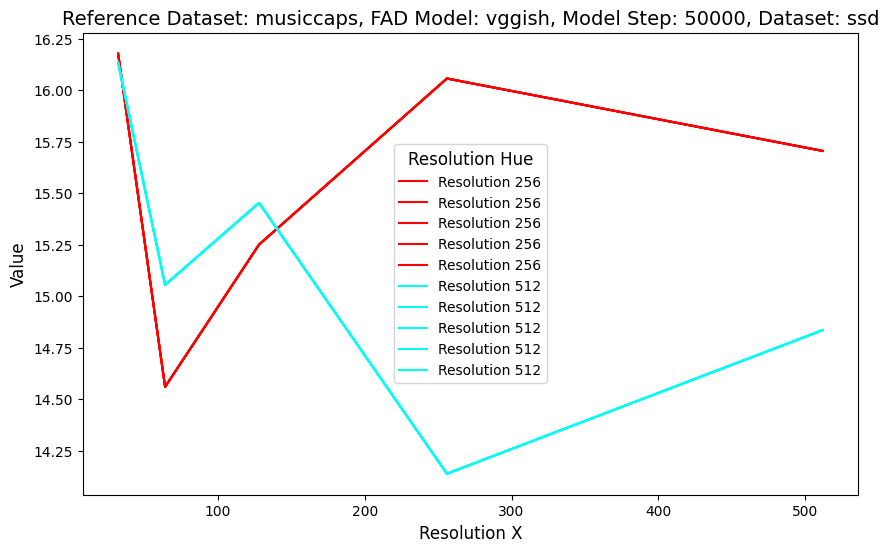

In [33]:
plot_filtered_data(result_df, 'ssd', 50000, 'vggish', 'musiccaps')

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_filtered_data(result_df, dataset, model_step, fad_model, reference_dataset):
    # Filter the dataframe based on the provided parameters
    filtered_df = result_df[
        (result_df['dataset'] == dataset) &
        (result_df['model_step'] == model_step) &
        (result_df['fad_model'] == fad_model)
    ]
    
    # Extract all unique resolutions from the DataFrame
    unique_resolutions = filtered_df['resolution'].unique()
    
    # Iterate over all possible resolution pairs
    for resolution_pair in unique_resolutions:
        # Split the resolution into two values
        resolution_hue, resolution_x = resolution_pair.split(',')
        
        # Convert the resolution columns to integers (if needed)
        resolution_hue = int(resolution_hue.strip())
        resolution_x = int(resolution_x.strip())
        
        # Filter the DataFrame further by resolution
        resolution_filtered_df = filtered_df[
            (filtered_df['resolution'] == resolution_pair)
        ]
        
        # Create the plot
        plt.figure(figsize=(10, 6))
        
        # Plot the data, using resolution_hue as hue and resolution_x as x-axis
        for hue_value in resolution_filtered_df[resolution_hue].unique():
            subset = resolution_filtered_df[resolution_filtered_df[resolution_hue] == hue_value]
            plt.plot(subset[resolution_x], subset['value'], label=f'Hue: {hue_value}')
        
        # Set the title with all required information
        plt.title(f"Reference Dataset: {reference_dataset}, FAD Model: {fad_model}, "
                  f"Model Step: {model_step}, Dataset: {dataset}, Resolution: {resolution_pair}")
        
        # Set the labels
        plt.xlabel(f'Resolution {resolution_x}')
        plt.ylabel('Value')
        
        # Show legend
        plt.legend(title=f'Resolution {resolution_hue}')
        
        # Show the plot
        plt.show()

# Example usage:
# plot_filtered_data(result_df, 'Dataset_A', 100, 'FAD_Model_1', 'Ref_Dataset_1')


In [60]:
plot_filtered_data(result_df, 'ssd', 50000, 'vggish', 'musiccaps')

# Load BASE results from tensorboard pythonically

In [52]:
log_dirs = ['hpc_tensorboard/models/mc_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_256_256/model_step_40000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_256_256/model_step_5000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_256_256/model_step_5000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_256_256/model_step_100/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_256_256/model_step_100/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_256_256/model_step_1000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_256_256/model_step_1000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_256_256/model_step_20000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_256_256/model_step_20000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_256_256/model_step_500/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_256_256/model_step_500/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_256_256/model_step_10000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_256_256/model_step_10000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_256_256/model_step_2500/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_256_256/model_step_2500/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/archive/ds_256_256/logs/train_unet', 'hpc_tensorboard/models/archive/mc_64_64/logs/train_unet', 'hpc_tensorboard/models/archive/ds_64_64_testing_hpc/logs/train_unet', 'hpc_tensorboard/models/archive/ds_64_64_testing_hpc/model_step_2000/samples', 'hpc_tensorboard/models/archive/mc_256_256/logs/train_unet', 'hpc_tensorboard/models/archive/ssd_256_256/logs/train_unet', 'hpc_tensorboard/models/archive/ds_64_64/logs/train_unet', 'hpc_tensorboard/models/archive/ssd_64_64/logs/train_unet', 'hpc_tensorboard/models/ds_64_64/model_step_500/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_64_64/model_step_500/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_64_64/model_step_10000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_64_64/model_step_10000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_64_64/model_step_2500/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_64_64/model_step_2500/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_64_64/model_step_40000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_64_64/model_step_40000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_64_64/model_step_5000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_64_64/model_step_5000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_64_64/model_step_1000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_64_64/model_step_1000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_64_64/samples/audio/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_64_64/samples/audio/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_64_64/model_step_20000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_64_64/model_step_20000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_64_64/model_step_100/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_64_64/model_step_100/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_256_256/model_step_1000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_256_256/model_step_1000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_256_256/model_step_10000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_256_256/model_step_10000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_256_256/model_step_500/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_256_256/model_step_500/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_256_256/model_step_5000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_256_256/model_step_5000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_256_256/model_step_40000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_256_256/model_step_100/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_256_256/model_step_100/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_256_256/model_step_2500/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_256_256/model_step_2500/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ds_256_256/model_step_20000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ds_256_256/model_step_20000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_256_256/model_step_20000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_256_256/model_step_20000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_256_256/model_step_500/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_256_256/model_step_500/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_256_256/model_step_2500/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_256_256/model_step_2500/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_256_256/model_step_1000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_256_256/model_step_1000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_256_256/model_step_10000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_256_256/model_step_10000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_256_256/model_step_5000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_256_256/model_step_5000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_256_256/model_step_100/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_256_256/model_step_100/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_64_64/model_step_500/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_64_64/model_step_500/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_64_64/model_step_5000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_64_64/model_step_5000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_64_64/model_step_20000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_64_64/model_step_20000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_64_64/model_step_40000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_64_64/model_step_40000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_64_64/model_step_1000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_64_64/model_step_1000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_64_64/model_step_2500/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_64_64/model_step_2500/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_64_64/model_step_10000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/ssd_64_64/model_step_10000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_64_64/model_step_100/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/ssd_64_64/model_step_100/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_64_64/model_step_5000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_64_64/model_step_5000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_64_64/model_step_40000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_64_64/model_step_40000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_64_64/model_step_1000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_64_64/model_step_1000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_64_64/model_step_20000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_64_64/model_step_20000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_64_64/model_step_100/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_64_64/model_step_100/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_64_64/model_step_500/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_64_64/model_step_500/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_64_64/model_step_10000/samples/sch_ddpm_nisteps_1000', 'hpc_tensorboard/models/mc_64_64/model_step_10000/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_64_64/model_step_2500/samples/sch_ddim_nisteps_100', 'hpc_tensorboard/models/mc_64_64/model_step_2500/samples/sch_ddpm_nisteps_1000']

log_dirs = ["../" + d for d in log_dirs]
log_dirs = [d for d in log_dirs if '/archive' not in d]
log_dirs = [d for d in log_dirs if 'audio' not in d]
ds_64_64_dirs = [d for d in log_dirs if '/ds_64_64' in d]
ds_256_256_dirs = [d for d in log_dirs if '/ds_256_256' in d]
mc_64_64_dirs = [d for d in log_dirs if '/mc_64_64' in d]
mc_256_256_dirs = [d for d in log_dirs if '/mc_256_256' in d]
ssd_64_64_dirs = [d for d in log_dirs if '/ssd_64_64' in d]
ssd_256_256_dirs = [d for d in log_dirs if '/ssd_256_256' in d]
all_dirs = [ds_64_64_dirs, ds_256_256_dirs, mc_64_64_dirs, mc_256_256_dirs, ssd_64_64_dirs, ssd_256_256_dirs]

In [53]:
ds_64_64_dirs

['../hpc_tensorboard/models/ds_64_64/model_step_500/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ds_64_64/model_step_500/samples/sch_ddim_nisteps_100',
 '../hpc_tensorboard/models/ds_64_64/model_step_10000/samples/sch_ddim_nisteps_100',
 '../hpc_tensorboard/models/ds_64_64/model_step_10000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ds_64_64/model_step_2500/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ds_64_64/model_step_2500/samples/sch_ddim_nisteps_100',
 '../hpc_tensorboard/models/ds_64_64/model_step_40000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ds_64_64/model_step_40000/samples/sch_ddim_nisteps_100',
 '../hpc_tensorboard/models/ds_64_64/model_step_5000/samples/sch_ddim_nisteps_100',
 '../hpc_tensorboard/models/ds_64_64/model_step_5000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ds_64_64/model_step_1000/samples/sch_ddim_nisteps_100',
 '../hpc_tensorboard/models/ds_64_64/model_step_1000/samples/sch_ddpm

In [58]:
all_scalars = []

for dir_list in all_dirs:
    for log_dir in dir_list:
        scalars = extract_scalars(log_dir)
        for tag, values in scalars.items():
            df = pd.DataFrame(values)
            df['log_dir'] = log_dir
            df['tag'] = tag
            all_scalars.append(df)

result_df = pd.concat(all_scalars, ignore_index=True)

result_df.to_csv('scalars.csv', index=False)


In [60]:
def extract_dataset(log_dir):
    return log_dir.split('/')[3].split('_')[0]

def extract_resolution(log_dir):
    return ','.join(log_dir.split('/')[3].split('_')[1:])

def extract_model_step(log_dir):
    return log_dir.split('/')[4].split('_')[2]

def extract_sampler(log_dir):
    return log_dir.split('/')[-1].split('_')[1]

result_df['dataset'] = result_df['log_dir'].apply(extract_dataset)
result_df['resolution'] = result_df['log_dir'].apply(extract_resolution)
result_df['model_step'] = result_df['log_dir'].apply(extract_model_step)
result_df['sampler'] = result_df['log_dir'].apply(extract_sampler)

def extract_fad_model(tag):
    return tag.split('fad_')[1].split('_ref')[0]

def extract_reference_dataset(tag):
    return tag.split('_ref_')[1].split('_gen')[0]

result_df['fad_model'] = result_df['tag'].apply(extract_fad_model)
result_df['reference_dataset'] = result_df['tag'].apply(extract_reference_dataset)

result_df.drop(columns=['log_dir', 'tag'], inplace=True)

['..', 'hpc_tensorboard', 'models', 'ds_64_64', 'model_step_500', 'samples', 'sch_ddpm_nisteps_1000']
['..', 'hpc_tensorboard', 'models', 'ds_64_64', 'model_step_500', 'samples', 'sch_ddpm_nisteps_1000']
['..', 'hpc_tensorboard', 'models', 'ds_64_64', 'model_step_500', 'samples', 'sch_ddpm_nisteps_1000']
['..', 'hpc_tensorboard', 'models', 'ds_64_64', 'model_step_500', 'samples', 'sch_ddpm_nisteps_1000']
['..', 'hpc_tensorboard', 'models', 'ds_64_64', 'model_step_500', 'samples', 'sch_ddpm_nisteps_1000']
['..', 'hpc_tensorboard', 'models', 'ds_64_64', 'model_step_500', 'samples', 'sch_ddpm_nisteps_1000']
['..', 'hpc_tensorboard', 'models', 'ds_64_64', 'model_step_500', 'samples', 'sch_ddpm_nisteps_1000']
['..', 'hpc_tensorboard', 'models', 'ds_64_64', 'model_step_500', 'samples', 'sch_ddpm_nisteps_1000']
['..', 'hpc_tensorboard', 'models', 'ds_64_64', 'model_step_500', 'samples', 'sch_ddpm_nisteps_1000']
['..', 'hpc_tensorboard', 'models', 'ds_64_64', 'model_step_500', 'samples', 'sch_

In [86]:
result_df['model_step'] = result_df['model_step'].astype(int)

In [65]:
result_df.to_csv('../results/base_evaluation_results.csv')

In [146]:
result_df[(result_df['dataset'] == 'ds') & (result_df['reference_dataset'] == 'drum_samples')]

wall_time  step      value dataset resolution  model_step sampler         fad_model reference_dataset
0    1.716267e+09     0   0.392850      ds      64,64         500    ddpm  clap-laion-audio      drum_samples
1    1.716267e+09     0   0.430554      ds      64,64         500    ddpm  clap-laion-music      drum_samples
2    1.716267e+09     0  11.005616      ds      64,64         500    ddpm   encodec-emb-48k      drum_samples
3    1.716267e+09     0  58.339176      ds      64,64         500    ddpm       encodec-emb      drum_samples
4    1.716267e+09     0  48.432827      ds      64,64         500    ddpm       MERT-v1-95M      drum_samples
..            ...   ...        ...     ...        ...         ...     ...               ...               ...
521  1.716263e+09     0   0.443980      ds    256,256       20000    ddpm  clap-laion-music      drum_samples
522  1.716263e+09     0  12.806067      ds    256,256       20000    ddpm            vggish      drum_samples
523  1.716263e+09     0  18.219641      ds    256,256       20000    ddpm   encodec-emb-48k      drum_samples
524  1.716263e+09     0  65.952942      ds    256,256       20000    ddpm       encodec-emb      drum_samples
525  1.716263e+09     0  27.298428      ds    256,256       20000    ddpm       MERT-v1-95M      drum_samples

[182 rows x 9 columns]

In [147]:
columns_to_check = ['dataset', 'resolution', 'model_step', 'sampler', 'fad_model', 'reference_dataset']
duplicate_rows = result_df[result_df.duplicated(subset=columns_to_check, keep=False)]

duplicate_rows

wall_time  step       value dataset resolution  model_step sampler         fad_model      reference_dataset
75    1.716242e+09     0    0.304784      ds      64,64        2500    ddim  clap-laion-audio           drum_samples
76    1.716267e+09     0    0.304787      ds      64,64        2500    ddim  clap-laion-audio           drum_samples
77    1.716242e+09     0    0.344378      ds      64,64        2500    ddim  clap-laion-music           drum_samples
78    1.716267e+09     0    0.344403      ds      64,64        2500    ddim  clap-laion-music           drum_samples
293   1.716242e+09     0    0.427110      ds    256,256       10000    ddim  clap-laion-audio           drum_samples
294   1.716253e+09     0    0.427070      ds    256,256       10000    ddim  clap-laion-audio           drum_samples
295   1.716242e+09     0    0.517897      ds    256,256       10000    ddim  clap-laion-music           drum_samples
296   1.716253e+09     0    0.517889      ds    256,256       10000    ddim  clap-laion-music           drum_samples
297   1.716242e+09     0   27.249901      ds    256,256       10000    ddim   encodec-emb-48k           drum_samples
298   1.716253e+09     0   13.074430      ds    256,256       10000    ddim   encodec-emb-48k           drum_samples
299   1.716242e+09     0   85.263405      ds    256,256       10000    ddim       encodec-emb           drum_samples
300   1.716253e+09     0   51.340725      ds    256,256       10000    ddim       encodec-emb           drum_samples
301   1.716242e+09     0   18.897856      ds    256,256       10000    ddim       MERT-v1-95M           drum_samples
302   1.716253e+09     0   18.897856      ds    256,256       10000    ddim       MERT-v1-95M           drum_samples
303   1.716243e+09     0    1.177716      ds    256,256       10000    ddim  clap-laion-audio              musiccaps
304   1.716253e+09     0    1.177716      ds    256,256       10000    ddim  clap-laion-audio              musiccaps
305   1.716243e+09     0    1.082627      ds    256,256       10000    ddim  clap-laion-music              musiccaps
306   1.716253e+09     0    1.082627      ds    256,256       10000    ddim  clap-laion-music              musiccaps
307   1.716243e+09     0   20.768839      ds    256,256       10000    ddim            vggish              musiccaps
308   1.716253e+09     0   20.768839      ds    256,256       10000    ddim            vggish              musiccaps
309   1.716243e+09     0   85.343361      ds    256,256       10000    ddim   encodec-emb-48k              musiccaps
310   1.716253e+09     0   85.343361      ds    256,256       10000    ddim   encodec-emb-48k              musiccaps
311   1.716243e+09     0  612.120422      ds    256,256       10000    ddim       encodec-emb              musiccaps
312   1.716253e+09     0  612.120422      ds    256,256       10000    ddim       encodec-emb              musiccaps
313   1.716243e+09     0   42.435417      ds    256,256       10000    ddim       MERT-v1-95M              musiccaps
314   1.716253e+09     0   42.435417      ds    256,256       10000    ddim       MERT-v1-95M              musiccaps
890   1.716268e+09     0    1.246466     ssd      64,64         500    ddpm  clap-laion-audio  spotify_sleep_dataset
891   1.716270e+09     0    1.246466     ssd      64,64         500    ddpm  clap-laion-audio  spotify_sleep_dataset
892   1.716268e+09     0    1.062901     ssd      64,64         500    ddpm  clap-laion-music  spotify_sleep_dataset
893   1.716270e+09     0    1.062901     ssd      64,64         500    ddpm  clap-laion-music  spotify_sleep_dataset
894   1.716268e+09     0   29.373318     ssd      64,64         500    ddpm   encodec-emb-48k  spotify_sleep_dataset
895   1.716270e+09     0   29.373318     ssd      64,64         500    ddpm   encodec-emb-48k  spotify_sleep_dataset
908   1.716268e+09     0    1.254691     ssd      64,64         500    ddim  clap-laion-audio  spotify_sleep_dataset
909   1.716271e+09     0    1.2

In [ ]:
51.340725 ds	256,256	10000	ddim	encodec-emb	drum_samples

27.249901 ds	256,256	10000	ddim	encodec-emb-48k	drum_samples

In [148]:
rows_to_remove = [
    [51.340725, 'ds', '256,256', '10000', 'ddim', 'encodec-emb', 'drum_samples'],
    [27.249901, 'ds', '256,256', '10000', 'ddim', 'encodec-emb-48k', 'drum_samples']
]

# Convert the list of rows to a DataFrame for easy comparison
rows_to_remove_df = pd.DataFrame(rows_to_remove, columns=['value', 'dataset', 'resolution', 'model_step', 'sampler', 'fad_model', 'reference_dataset'])


In [149]:
result_df_filtered = result_df[~result_df.isin(rows_to_remove_df.to_dict(orient='list')).all(axis=1)]

In [151]:
columns_to_check = ['dataset', 'resolution', 'model_step', 'sampler', 'fad_model', 'reference_dataset']
duplicate_rows = result_df_filtered[result_df_filtered.duplicated(subset=columns_to_check, keep=False)]

duplicate_rows

wall_time  step       value dataset resolution  model_step sampler         fad_model      reference_dataset
75    1.716242e+09     0    0.304784      ds      64,64        2500    ddim  clap-laion-audio           drum_samples
76    1.716267e+09     0    0.304787      ds      64,64        2500    ddim  clap-laion-audio           drum_samples
77    1.716242e+09     0    0.344378      ds      64,64        2500    ddim  clap-laion-music           drum_samples
78    1.716267e+09     0    0.344403      ds      64,64        2500    ddim  clap-laion-music           drum_samples
293   1.716242e+09     0    0.427110      ds    256,256       10000    ddim  clap-laion-audio           drum_samples
294   1.716253e+09     0    0.427070      ds    256,256       10000    ddim  clap-laion-audio           drum_samples
295   1.716242e+09     0    0.517897      ds    256,256       10000    ddim  clap-laion-music           drum_samples
296   1.716253e+09     0    0.517889      ds    256,256       10000    ddim  clap-laion-music           drum_samples
297   1.716242e+09     0   27.249901      ds    256,256       10000    ddim   encodec-emb-48k           drum_samples
298   1.716253e+09     0   13.074430      ds    256,256       10000    ddim   encodec-emb-48k           drum_samples
299   1.716242e+09     0   85.263405      ds    256,256       10000    ddim       encodec-emb           drum_samples
300   1.716253e+09     0   51.340725      ds    256,256       10000    ddim       encodec-emb           drum_samples
301   1.716242e+09     0   18.897856      ds    256,256       10000    ddim       MERT-v1-95M           drum_samples
302   1.716253e+09     0   18.897856      ds    256,256       10000    ddim       MERT-v1-95M           drum_samples
303   1.716243e+09     0    1.177716      ds    256,256       10000    ddim  clap-laion-audio              musiccaps
304   1.716253e+09     0    1.177716      ds    256,256       10000    ddim  clap-laion-audio              musiccaps
305   1.716243e+09     0    1.082627      ds    256,256       10000    ddim  clap-laion-music              musiccaps
306   1.716253e+09     0    1.082627      ds    256,256       10000    ddim  clap-laion-music              musiccaps
307   1.716243e+09     0   20.768839      ds    256,256       10000    ddim            vggish              musiccaps
308   1.716253e+09     0   20.768839      ds    256,256       10000    ddim            vggish              musiccaps
309   1.716243e+09     0   85.343361      ds    256,256       10000    ddim   encodec-emb-48k              musiccaps
310   1.716253e+09     0   85.343361      ds    256,256       10000    ddim   encodec-emb-48k              musiccaps
311   1.716243e+09     0  612.120422      ds    256,256       10000    ddim       encodec-emb              musiccaps
312   1.716253e+09     0  612.120422      ds    256,256       10000    ddim       encodec-emb              musiccaps
313   1.716243e+09     0   42.435417      ds    256,256       10000    ddim       MERT-v1-95M              musiccaps
314   1.716253e+09     0   42.435417      ds    256,256       10000    ddim       MERT-v1-95M              musiccaps
890   1.716268e+09     0    1.246466     ssd      64,64         500    ddpm  clap-laion-audio  spotify_sleep_dataset
891   1.716270e+09     0    1.246466     ssd      64,64         500    ddpm  clap-laion-audio  spotify_sleep_dataset
892   1.716268e+09     0    1.062901     ssd      64,64         500    ddpm  clap-laion-music  spotify_sleep_dataset
893   1.716270e+09     0    1.062901     ssd      64,64         500    ddpm  clap-laion-music  spotify_sleep_dataset
894   1.716268e+09     0   29.373318     ssd      64,64         500    ddpm   encodec-emb-48k  spotify_sleep_dataset
895   1.716270e+09     0   29.373318     ssd      64,64         500    ddpm   encodec-emb-48k  spotify_sleep_dataset
908   1.716268e+09     0    1.254691     ssd      64,64         500    ddim  clap-laion-audio  spotify_sleep_dataset
909   1.716271e+09     0    1.2

In [2]:
result_df = pd.read_csv('../results/base_evaluation_results.csv')

In [159]:
# result_df.to_csv('../results/base_evaluation_results.csv')

drum samples cross reference - vggish - 0.17949207689641256
drum samples cross reference - clap-laion-audio - 0.014324303916341208

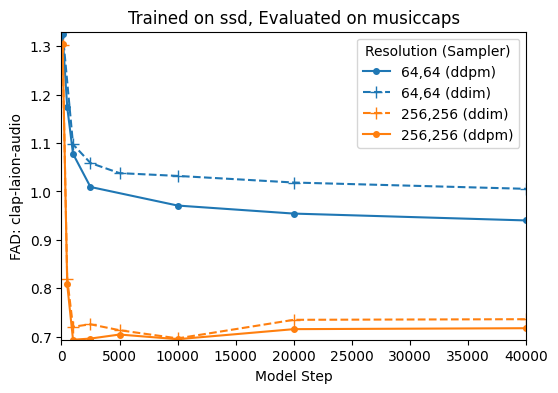

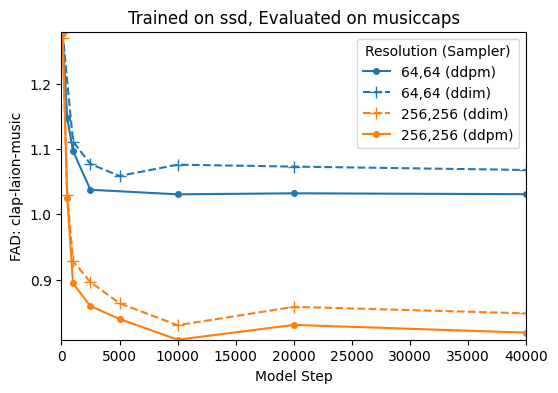

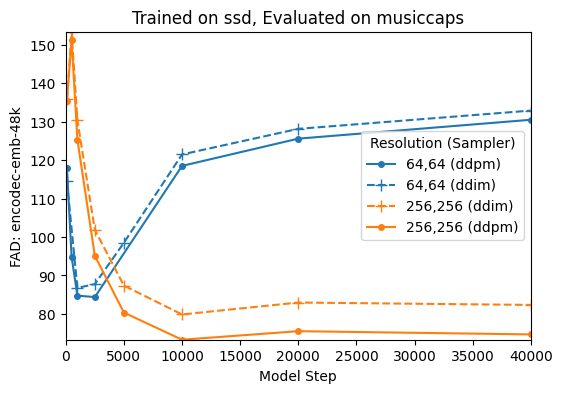

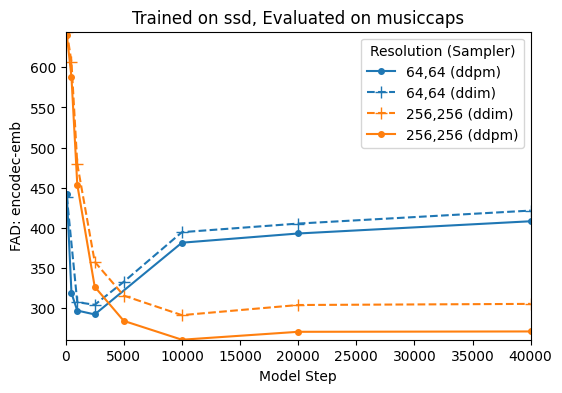

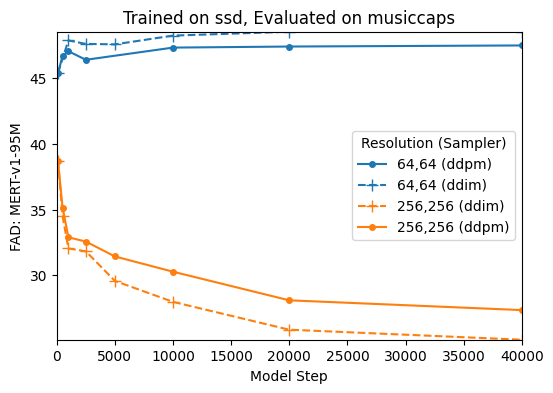

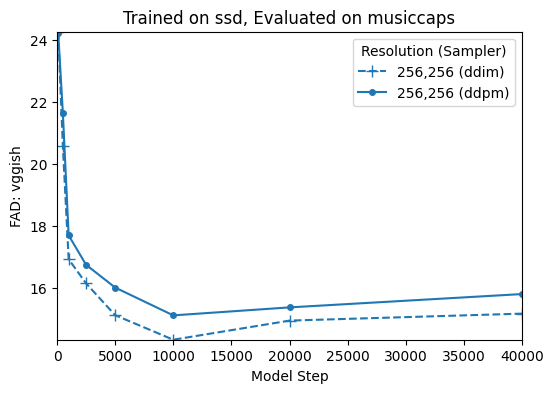

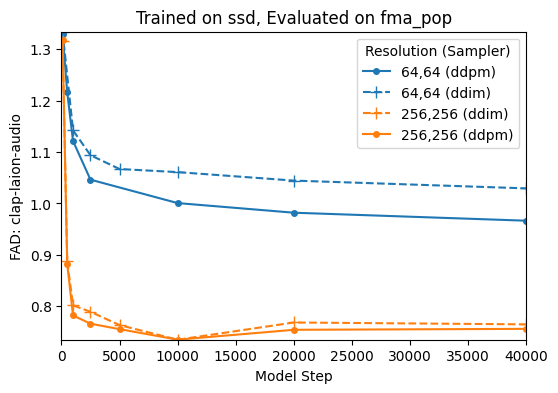

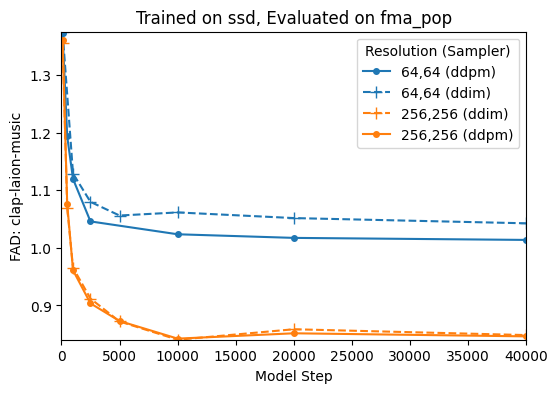

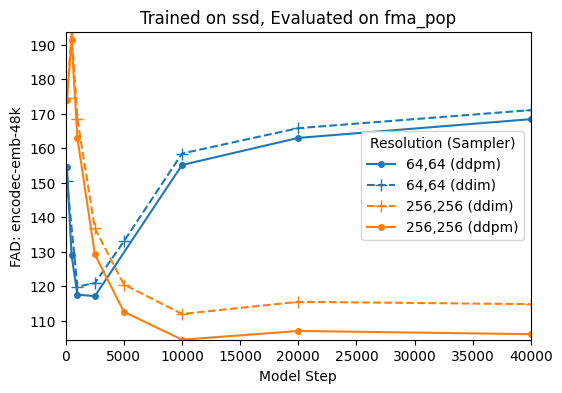

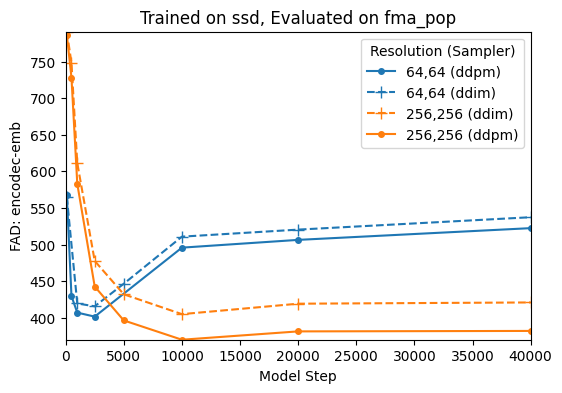

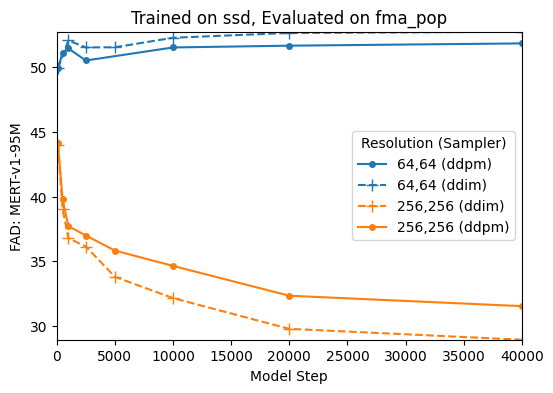

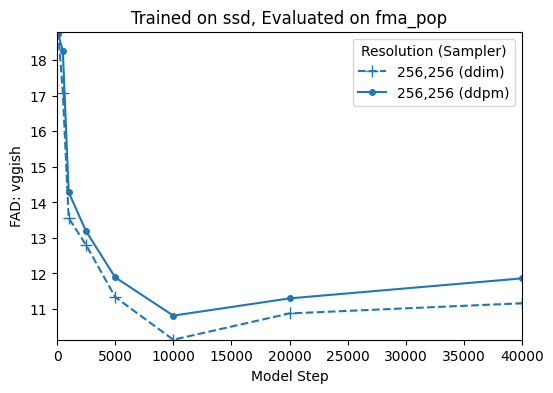

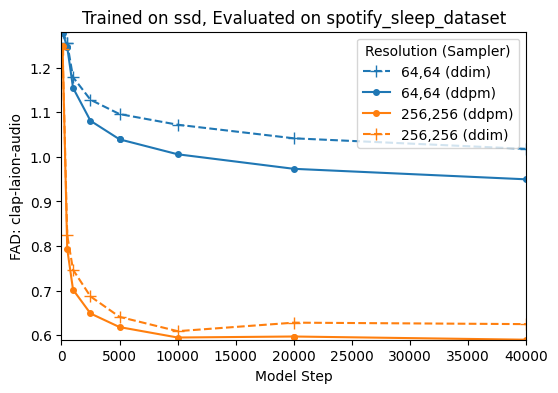

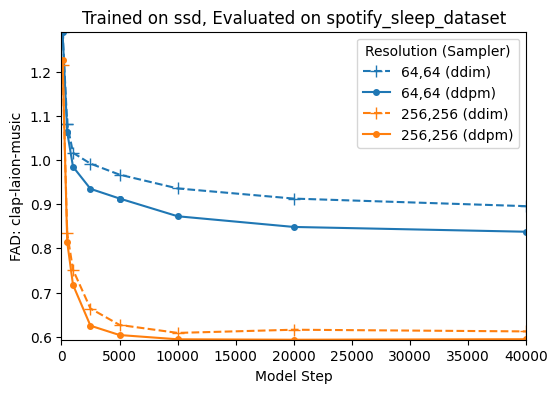

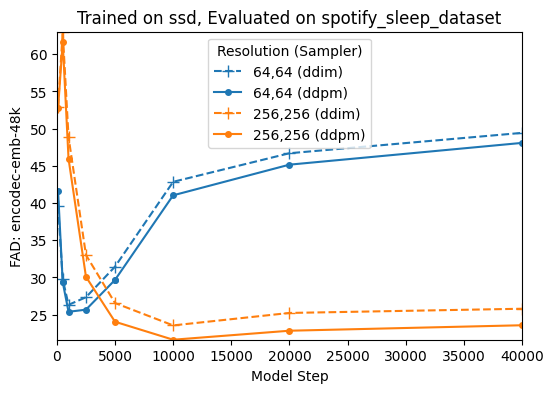

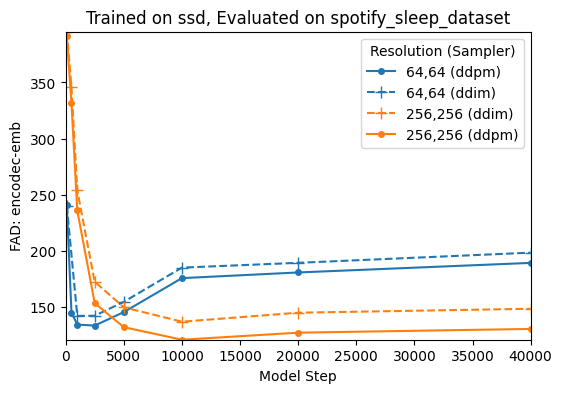

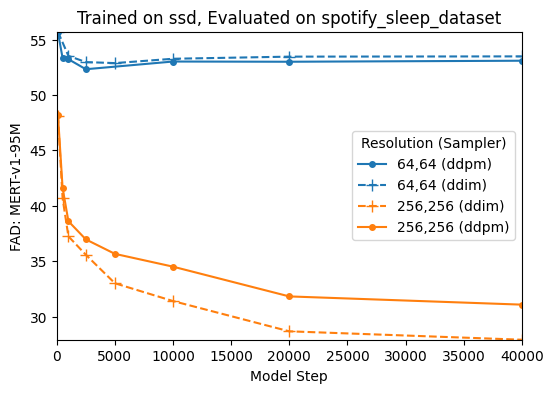

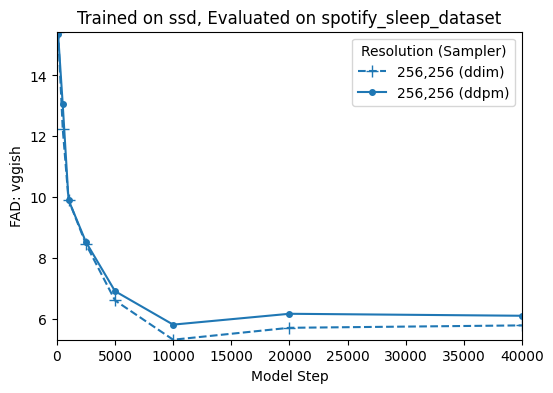

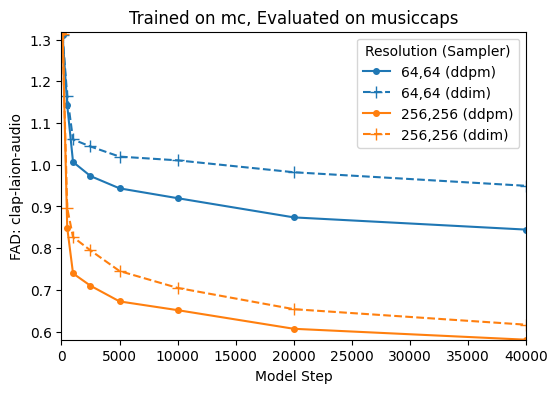

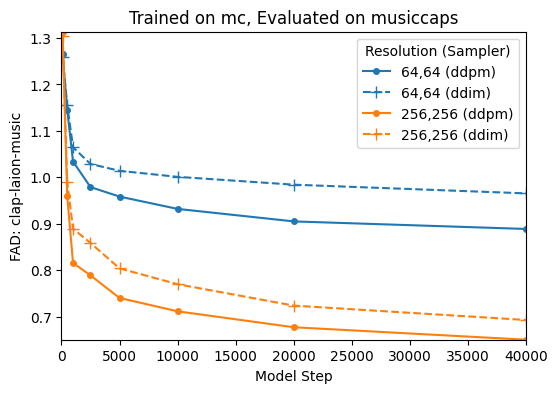

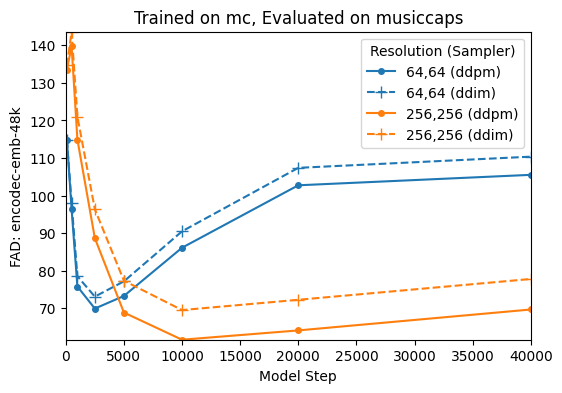

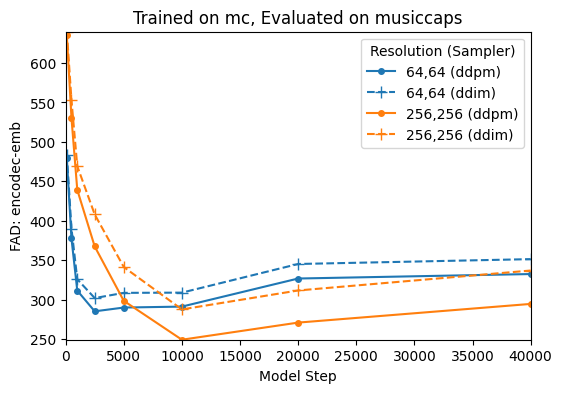

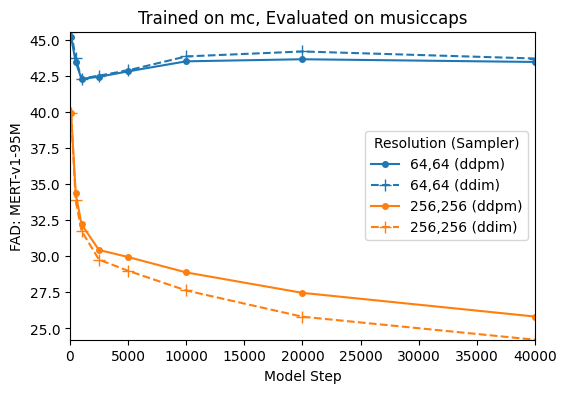

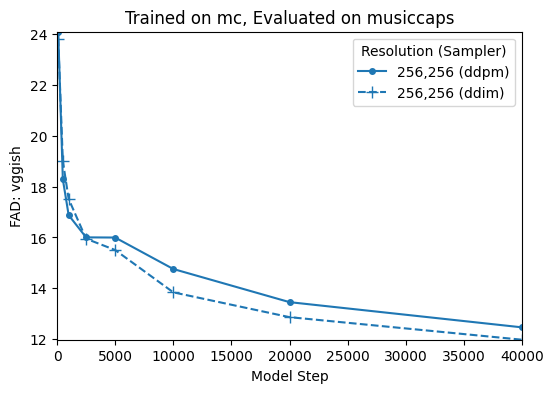

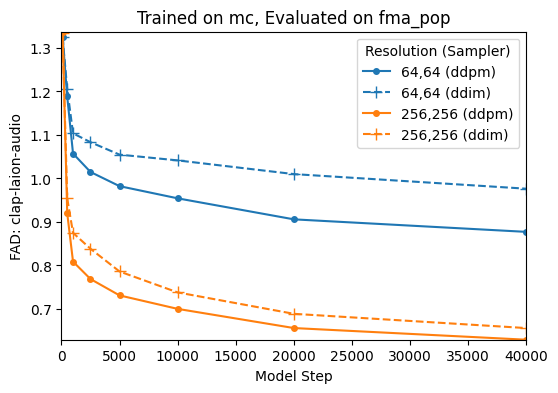

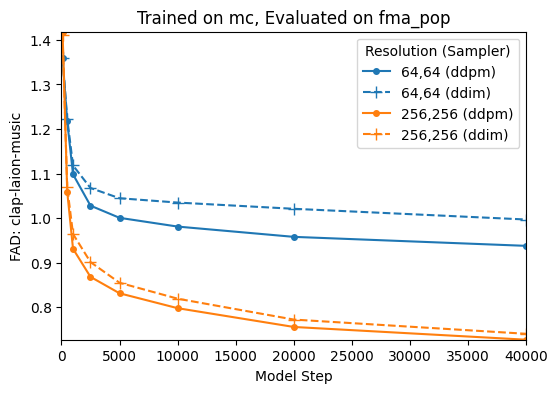

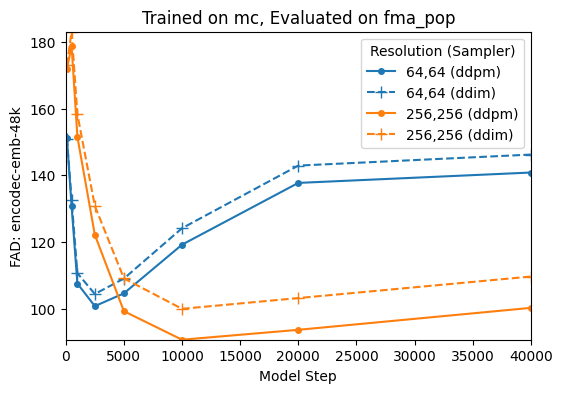

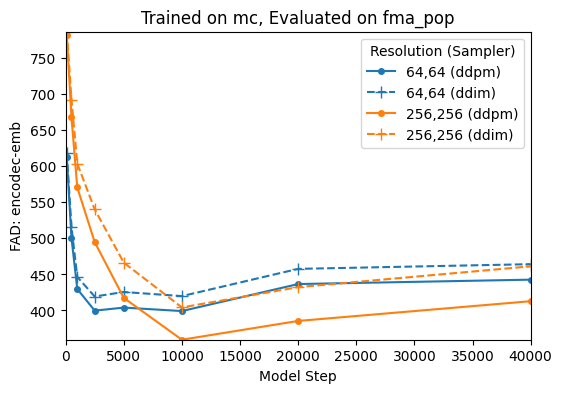

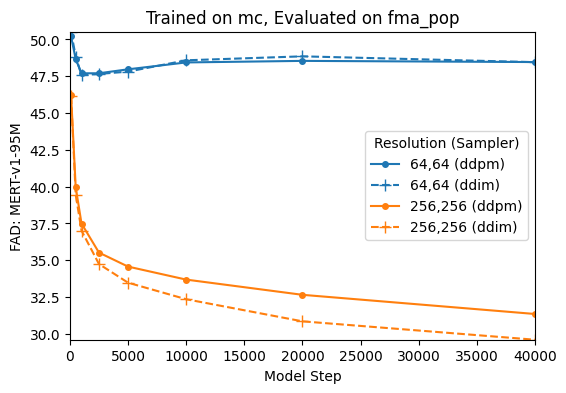

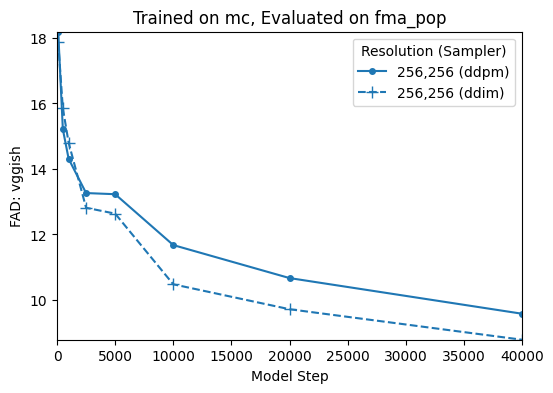

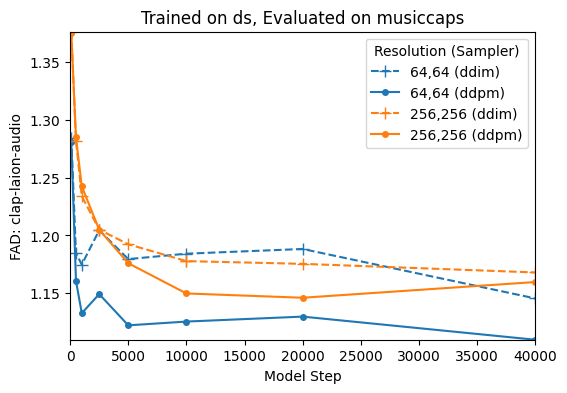

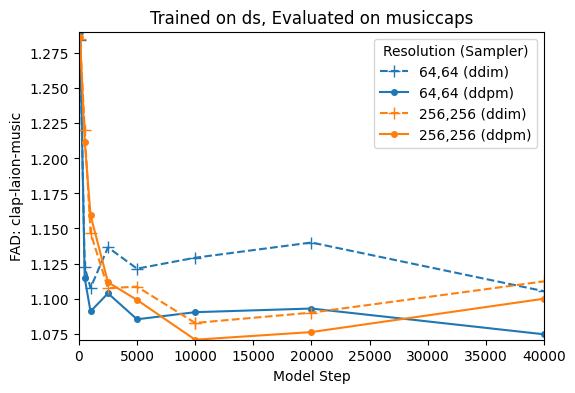

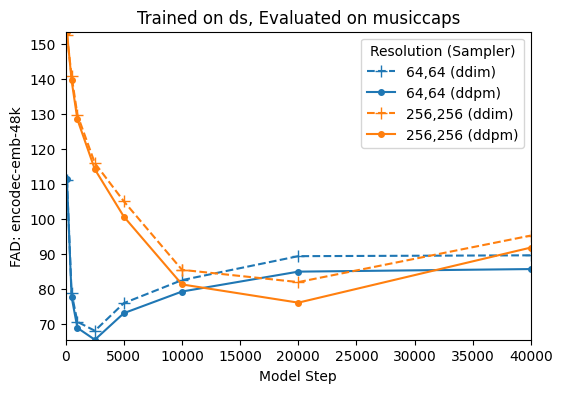

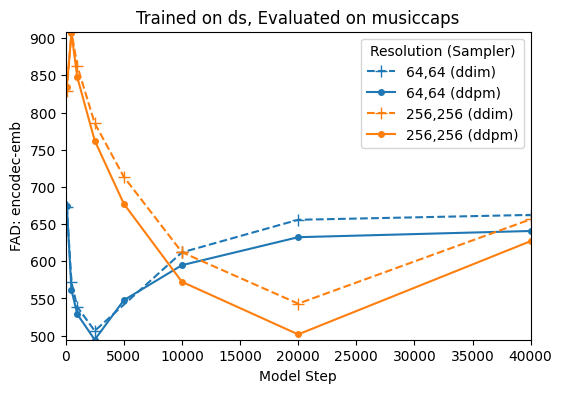

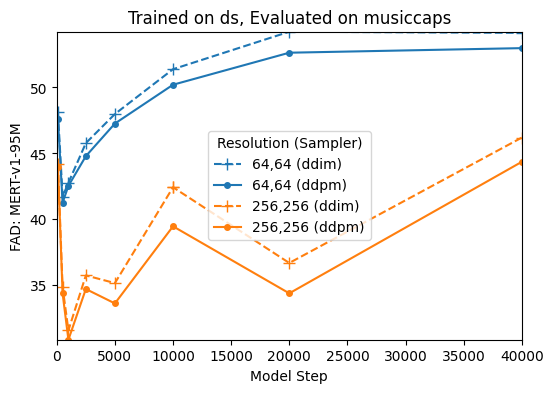

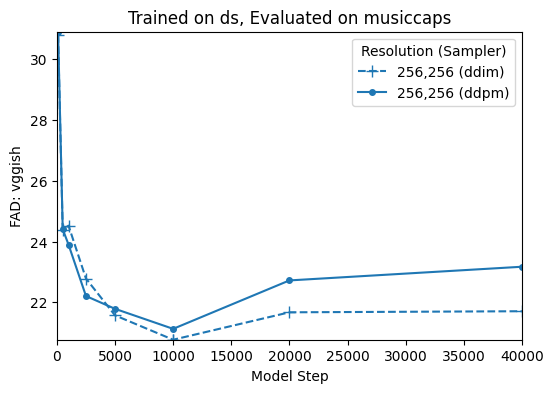

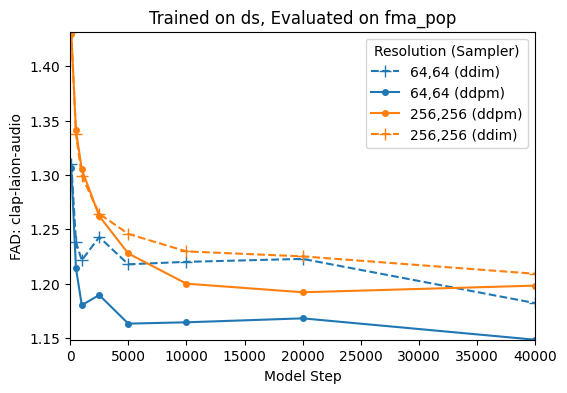

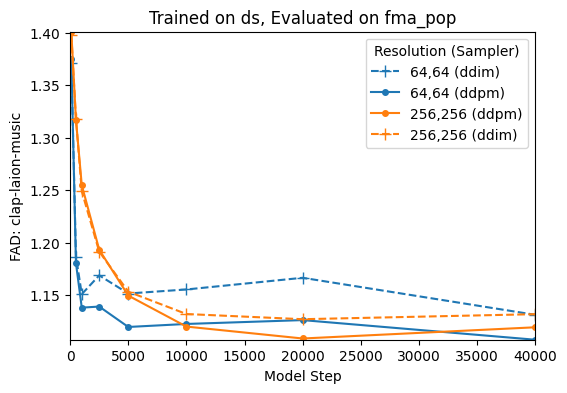

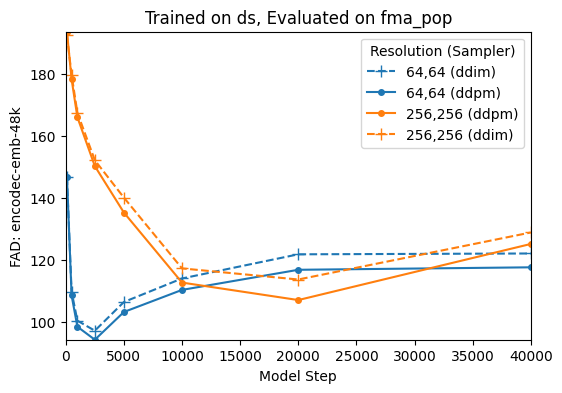

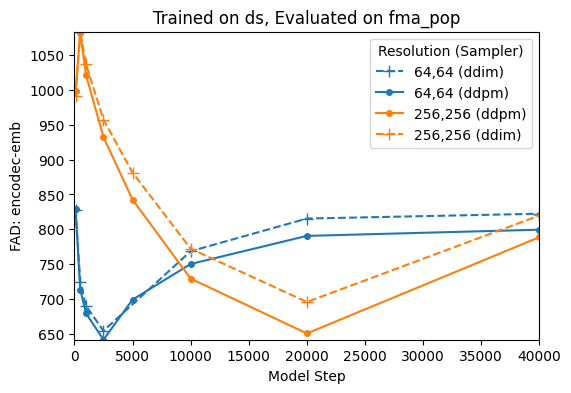

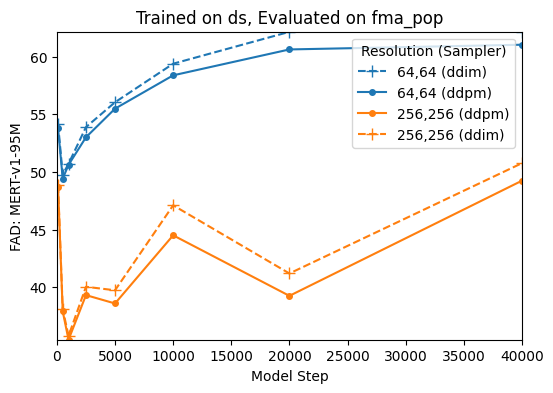

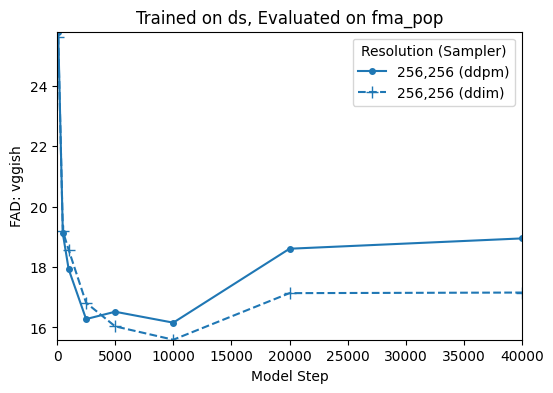

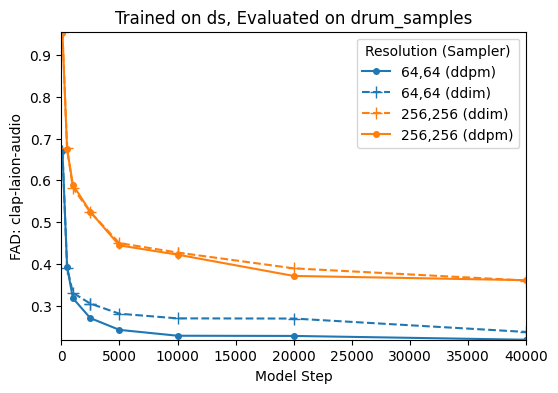

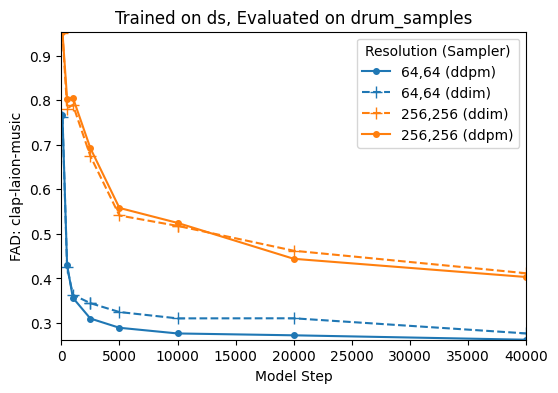

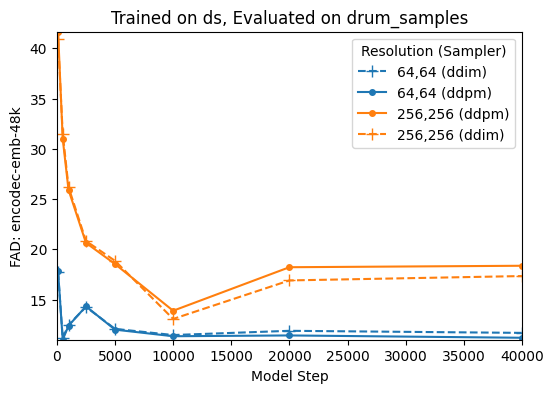

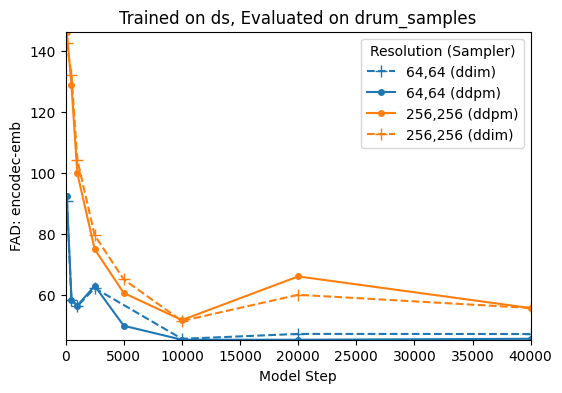

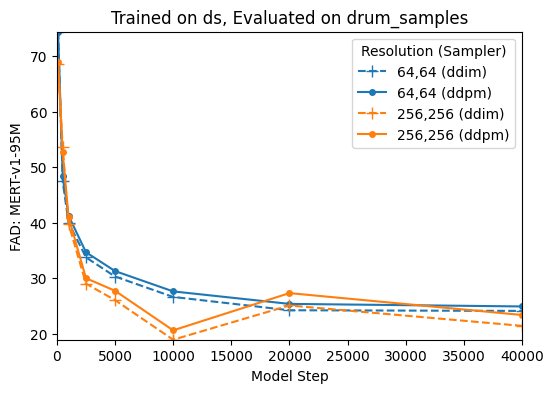

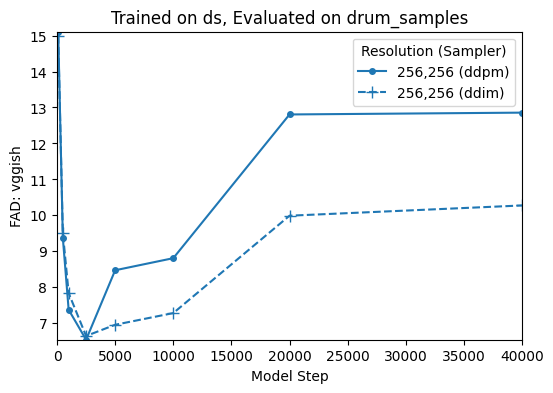

In [160]:
datasets = ['ssd', 'mc', 'ds']
reference_datasets = ['musiccaps', 'fma_pop', 'spotify_sleep_dataset', 'drum_samples']
models = ['clap-laion-audio', 'clap-laion-music', 'encodec-emb-48k', 'encodec-emb', 'MERT-v1-95M', 'vggish']

for d in datasets:
    for r in reference_datasets:
        for m in models:
            plot_fad_scores(result_df, d, r, m)

        

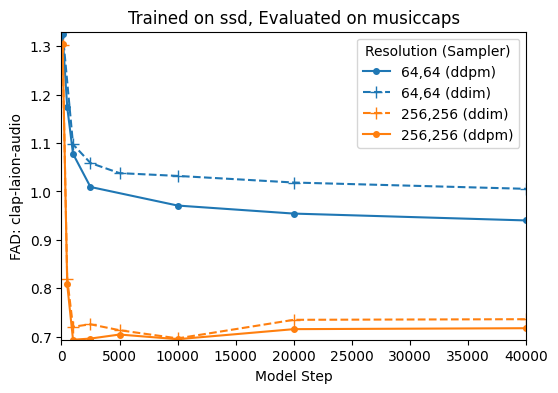

In [132]:
plot_fad_scores(result_df, 'ssd', 'musiccaps', 'clap-laion-audio')

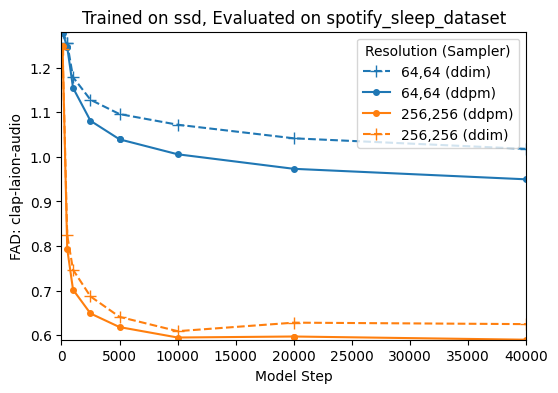

In [133]:
plot_fad_scores(result_df, 'ssd', 'spotify_sleep_dataset', 'clap-laion-audio')

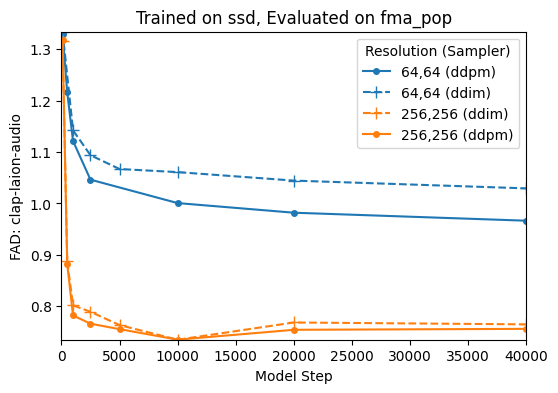

In [134]:
plot_fad_scores(result_df, 'ssd', 'fma_pop', 'clap-laion-audio')

# Load VAE results pythonically

In [23]:
log_dirs = []
for base_model in ['vae_ds_256_256', 'vae_ssd_256_256', 'vae_mc_256_256']:
    for model_step in [100, 500, 1000, 2500, 5000, 10000, 20000, 40000]:
        for inf_path in ['sch_ddpm_nisteps_1000', 'sch_ddim_nisteps_100']:
            path = f'hpc_tensorboard/models/{base_model}/model_step_{model_step}/samples/{inf_path}/'
            log_dirs.append(path)

In [24]:
log_dirs

['hpc_tensorboard/models/vae_ds_256_256/model_step_100/samples/sch_ddpm_nisteps_1000/',
 'hpc_tensorboard/models/vae_ds_256_256/model_step_100/samples/sch_ddim_nisteps_100/',
 'hpc_tensorboard/models/vae_ds_256_256/model_step_500/samples/sch_ddpm_nisteps_1000/',
 'hpc_tensorboard/models/vae_ds_256_256/model_step_500/samples/sch_ddim_nisteps_100/',
 'hpc_tensorboard/models/vae_ds_256_256/model_step_1000/samples/sch_ddpm_nisteps_1000/',
 'hpc_tensorboard/models/vae_ds_256_256/model_step_1000/samples/sch_ddim_nisteps_100/',
 'hpc_tensorboard/models/vae_ds_256_256/model_step_2500/samples/sch_ddpm_nisteps_1000/',
 'hpc_tensorboard/models/vae_ds_256_256/model_step_2500/samples/sch_ddim_nisteps_100/',
 'hpc_tensorboard/models/vae_ds_256_256/model_step_5000/samples/sch_ddpm_nisteps_1000/',
 'hpc_tensorboard/models/vae_ds_256_256/model_step_5000/samples/sch_ddim_nisteps_100/',
 'hpc_tensorboard/models/vae_ds_256_256/model_step_10000/samples/sch_ddpm_nisteps_1000/',
 'hpc_tensorboard/models/vae_

In [25]:
# log_dirs = [
#     'hpc_tensorboard/models/vae_ds_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000/',
#     'hpc_tensorboard/models/vae_ds_256_256/model_step_40000/samples/sch_ddim_nisteps_100/',
#     'hpc_tensorboard/models/vae_ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000/',
#     'hpc_tensorboard/models/vae_ssd_256_256/model_step_40000/samples/sch_ddim_nisteps_100/',
#     'hpc_tensorboard/models/vae_mc_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000/',
#     'hpc_tensorboard/models/vae_mc_256_256/model_step_40000/samples/sch_ddim_nisteps_100/'
# ]
          
log_dirs = ["../" + d for d in log_dirs]
log_dirs = [d for d in log_dirs if '/archive' not in d]
log_dirs = [d for d in log_dirs if 'audio' not in d]
vae_ds_dirs = [d for d in log_dirs if '/vae_ds' in d]
vae_ssd_dirs = [d for d in log_dirs if '/vae_ssd' in d]
vae_mc_dirs = [d for d in log_dirs if '/vae_mc' in d]
all_dirs = [vae_ds_dirs, vae_ssd_dirs, vae_mc_dirs]

In [43]:
# Extract scalars from all directories and combine into a single DataFrame
all_scalars = []

for dir_list in all_dirs:
    for log_dir in dir_list:
        print(log_dir)
        scalars = extract_scalars(log_dir)
        for tag, values in scalars.items():
            df = pd.DataFrame(values)
            df['log_dir'] = log_dir
            df['tag'] = tag
            all_scalars.append(df)

# Combine all dataframes
result_df = pd.concat(all_scalars, ignore_index=True)

# Save the DataFrame to a CSV file
result_df.to_csv('vae_scalars.csv', index=False)


../hpc_tensorboard/models/vae_ds_256_256/model_step_100/samples/sch_ddpm_nisteps_1000/
../hpc_tensorboard/models/vae_ds_256_256/model_step_100/samples/sch_ddim_nisteps_100/
../hpc_tensorboard/models/vae_ds_256_256/model_step_500/samples/sch_ddpm_nisteps_1000/
../hpc_tensorboard/models/vae_ds_256_256/model_step_500/samples/sch_ddim_nisteps_100/
../hpc_tensorboard/models/vae_ds_256_256/model_step_1000/samples/sch_ddpm_nisteps_1000/
../hpc_tensorboard/models/vae_ds_256_256/model_step_1000/samples/sch_ddim_nisteps_100/
../hpc_tensorboard/models/vae_ds_256_256/model_step_2500/samples/sch_ddpm_nisteps_1000/
../hpc_tensorboard/models/vae_ds_256_256/model_step_2500/samples/sch_ddim_nisteps_100/
../hpc_tensorboard/models/vae_ds_256_256/model_step_5000/samples/sch_ddpm_nisteps_1000/
../hpc_tensorboard/models/vae_ds_256_256/model_step_5000/samples/sch_ddim_nisteps_100/
../hpc_tensorboard/models/vae_ds_256_256/model_step_10000/samples/sch_ddpm_nisteps_1000/
../hpc_tensorboard/models/vae_ds_256_256

In [44]:
# Function to extract dataset
def extract_dataset(log_dir):
    if 'vae' not in log_dir:
        return log_dir.split('/')[3].split('_')[0]
    else:
        return log_dir.split('/')[3].split('_')[1]

# Function to extract resolution
def extract_resolution(log_dir):
    return ','.join(log_dir.split('/')[3].split('_')[2:])

# Function to extract model_step
def extract_model_step(log_dir):
    print(log_dir.split('/')[4].split('_')[2])
    return log_dir.split('/')[4].split('_')[2]

# Function to extract sampler
def extract_sampler(log_dir):
    return log_dir.split('/')[-2].split('_')[1]

# Function to extract sampler
def extract_vae(log_dir):
    if 'vae' in log_dir:
        return log_dir.split('/')[3].split('_')[0]
    else:
        return None


# Apply the functions to create new columns
result_df['dataset'] = result_df['log_dir'].apply(extract_dataset)
result_df['resolution'] = result_df['log_dir'].apply(extract_resolution)
result_df['model_step'] = result_df['log_dir'].apply(extract_model_step)
result_df['sampler'] = result_df['log_dir'].apply(extract_sampler)
result_df['vae'] = result_df['log_dir'].apply(extract_vae)

# Function to extract fad_model
def extract_fad_model(tag):
    return tag.split('fad_')[1].split('_ref')[0]

# Function to extract reference_dataset
def extract_reference_dataset(tag):
    return tag.split('_ref_')[1].split('_gen')[0]

# Apply the functions to create new columns
result_df['fad_model'] = result_df['tag'].apply(extract_fad_model)
result_df['reference_dataset'] = result_df['tag'].apply(extract_reference_dataset)

# Drop the original 'log_dir' and 'tag' columns if no longer needed
result_df.drop(columns=['log_dir', 'tag'], inplace=True)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Cleaned Results DataFrame", dataframe=result_df)


100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
2500
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
5000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
20000
40000
40000
40000
40000
40000
40000
40000
40000
40000
40000
40000
40000
40000
40000
40000
40000
40000
40000
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100
100

In [45]:
result_df

wall_time  step      value dataset resolution model_step sampler  vae         fad_model reference_dataset
0    1.716550e+09     0   1.174449      ds    256,256        100    ddpm  vae  clap-laion-audio           fma_pop
1    1.716550e+09     0   1.160421      ds    256,256        100    ddpm  vae  clap-laion-music           fma_pop
2    1.716550e+09     0  19.601179      ds    256,256        100    ddpm  vae            vggish           fma_pop
3    1.716550e+09     0   1.123486      ds    256,256        100    ddpm  vae  clap-laion-audio         musiccaps
4    1.716550e+09     0   1.078583      ds    256,256        100    ddpm  vae  clap-laion-music         musiccaps
..            ...   ...        ...     ...        ...        ...     ...  ...               ...               ...
572  1.716454e+09     0   0.795302      mc    256,256      40000    ddim  vae  clap-laion-music           fma_pop
573  1.716454e+09     0  10.099151      mc    256,256      40000    ddim  vae            vggish           fma_pop
574  1.716454e+09     0   0.579356      mc    256,256      40000    ddim  vae  clap-laion-audio         musiccaps
575  1.716454e+09     0   0.711340      mc    256,256      40000    ddim  vae  clap-laion-music         musiccaps
576  1.716454e+09     0  12.794442      mc    256,256      40000    ddim  vae            vggish         musiccaps

[577 rows x 10 columns]

In [47]:
result_df[result_df['model_step'] == '40000']

wall_time  step      value dataset resolution model_step sampler  vae         fad_model reference_dataset
157  1.716453e+09     0   0.426187      ds    256,256      40000    ddpm  vae  clap-laion-audio      drum_samples
158  1.716453e+09     0   0.488804      ds    256,256      40000    ddpm  vae  clap-laion-music      drum_samples
159  1.716453e+09     0   5.639660      ds    256,256      40000    ddpm  vae            vggish      drum_samples
160  1.716453e+09     0   1.333413      ds    256,256      40000    ddpm  vae  clap-laion-audio           fma_pop
161  1.716453e+09     0   1.353575      ds    256,256      40000    ddpm  vae  clap-laion-music           fma_pop
162  1.716454e+09     0  16.386065      ds    256,256      40000    ddpm  vae            vggish           fma_pop
163  1.716454e+09     0   1.338016      ds    256,256      40000    ddpm  vae  clap-laion-audio         musiccaps
164  1.716454e+09     0   1.396448      ds    256,256      40000    ddpm  vae  clap-laion-music         musiccaps
165  1.716454e+09     0  24.008320      ds    256,256      40000    ddpm  vae            vggish         musiccaps
166  1.716453e+09     0   0.428101      ds    256,256      40000    ddim  vae  clap-laion-audio      drum_samples
167  1.716453e+09     0   0.486727      ds    256,256      40000    ddim  vae  clap-laion-music      drum_samples
168  1.716453e+09     0   5.716456      ds    256,256      40000    ddim  vae            vggish      drum_samples
169  1.716453e+09     0   1.348335      ds    256,256      40000    ddim  vae  clap-laion-audio           fma_pop
170  1.716453e+09     0   1.364668      ds    256,256      40000    ddim  vae  clap-laion-music           fma_pop
171  1.716454e+09     0  16.525663      ds    256,256      40000    ddim  vae            vggish           fma_pop
172  1.716454e+09     0   1.354598      ds    256,256      40000    ddim  vae  clap-laion-audio         musiccaps
173  1.716454e+09     0   1.408534      ds    256,256      40000    ddim  vae  clap-laion-music         musiccaps
174  1.716454e+09     0  24.166660      ds    256,256      40000    ddim  vae            vggish         musiccaps
385  1.716453e+09     0   0.751521     ssd    256,256      40000    ddpm  vae  clap-laion-audio           fma_pop
386  1.716453e+09     0   0.930351     ssd    256,256      40000    ddpm  vae  clap-laion-music           fma_pop
387  1.716454e+09     0  12.346002     ssd    256,256      40000    ddpm  vae            vggish           fma_pop
388  1.716454e+09     0   0.709145     ssd    256,256      40000    ddpm  vae  clap-laion-audio         musiccaps
389  1.716454e+09     0   0.927216     ssd    256,256      40000    ddpm  vae  clap-laion-music         musiccaps
390  1.716454e+09     0  16.297665     ssd    256,256      40000    ddpm  vae            vggish         musiccaps
391  1.716453e+09     0   0.769454     ssd    256,256      40000    ddim  vae  clap-laion-audio           fma_pop
392  1.716453e+09     0   0.927426     ssd    256,256      40000    ddim  vae  clap-laion-music           fma_pop
393  1.716454e+09     0  12.739934     ssd    256,256      40000    ddim  vae            vggish           fma_pop
394  1.716454e+09     0   0.731220     ssd    256,256      40000    ddim  vae  clap-laion-audio         musiccaps
395  1.716454e+09     0   0.937426     ssd    256,256      40000    ddim  vae  clap-laion-music         musiccaps
396  1.716454e+09     0  16.986639     ssd    256,256      40000    ddim  vae            vggish         musiccaps
565  1.716454e+09     0   0.642726      mc    256,256      40000    ddpm  vae  clap-laion-audio           fma_pop
566  1.716454e+09     0   0.806712      mc    256,256      40000    ddpm  vae  clap-laion-music           fma_pop
567  1.716454e+09     0   9.801196      mc    256,256      40000    ddpm  vae            vggish           fma_pop
568  1.716454e+09     0   0.572199      mc    256,256      40000    ddpm  vae  clap-laion-audio         musiccaps
569  1.716454e+09 

In [96]:
result_df.to_csv('../results/vae_evaluation_results.csv')

In [49]:
vae_result_df = pd.read_csv('../results/vae_evaluation_results.csv')
base_result_df = pd.read_csv('../results/base_evaluation_results.csv')

In [50]:
concat_df = pd.concat([vae_result_df, base_result_df])

In [51]:
concat_df

Unnamed: 0     wall_time  step       value dataset resolution  model_step sampler  vae         fad_model reference_dataset
0              0  1.716550e+09     0    1.174449      ds    256,256         100    ddpm  vae  clap-laion-audio           fma_pop
1              1  1.716550e+09     0    1.160421      ds    256,256         100    ddpm  vae  clap-laion-music           fma_pop
2              2  1.716550e+09     0   19.601179      ds    256,256         100    ddpm  vae            vggish           fma_pop
3              3  1.716550e+09     0    1.123486      ds    256,256         100    ddpm  vae  clap-laion-audio         musiccaps
4              4  1.716550e+09     0    1.078583      ds    256,256         100    ddpm  vae  clap-laion-music         musiccaps
...          ...           ...   ...         ...     ...        ...         ...     ...  ...               ...               ...
1397        1399  1.716266e+09     0    1.278465     ssd    256,256         100    ddpm  NaN  clap-laion-music         musiccaps
1398        1400  1.716266e+09     0   24.246433     ssd    256,256         100    ddpm  NaN            vggish         musiccaps
1399        1401  1.716267e+09     0  135.416168     ssd    256,256         100    ddpm  NaN   encodec-emb-48k         musiccaps
1400        1402  1.716267e+09     0  640.542419     ssd    256,256         100    ddpm  NaN       encodec-emb         musiccaps
1401        1403  1.716267e+09     0   38.720860     ssd    256,256         100    ddpm  NaN       MERT-v1-95M         musiccaps

[1979 rows x 11 columns]

In [ ]:
datasets = ['ssd', 'mc', 'ds']
reference_datasets = ['musiccaps', 'fma_pop', 'spotify_sleep_dataset', 'drum_samples']
models = ['clap-laion-audio', 'clap-laion-music', 'encodec-emb-48k', 'encodec-emb', 'MERT-v1-95M', 'vggish']

for d in datasets:
    for r in reference_datasets:
        for m in models:
            plot_fad_scores_w_vae(result_df, d, r, m)

In [52]:
plot_fad_scores_w_vae(concat_df, 'ssd', 'spotify_sleep_dataset', 'vggish', plot_vae=True)

/tmp/ipykernel_1727052/3991364001.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_vae = plt.cm.get_cmap('Pastel1')(np.arange(len(resolutions)))


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp4tkal6l8 79312b8cb968fd75b1512f99d68eec6b.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./79312b8cb968fd75b1512f99d68eec6b.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp4tkal6l8/79312b8cb968fd75b1512f99d68eec6b.log.




Error in callback <function _draw_all_if_interactive at 0x7625db05a020> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp2wjfjplj 79312b8cb968fd75b1512f99d68eec6b.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./79312b8cb968fd75b1512f99d68eec6b.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp2wjfjplj/79312b8cb968fd75b1512f99d68eec6b.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp7kj3a7ev 79312b8cb968fd75b1512f99d68eec6b.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./79312b8cb968fd75b1512f99d68eec6b.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp7kj3a7ev/79312b8cb968fd75b1512f99d68eec6b.log.




<Figure size 600x400 with 1 Axes>

/tmp/ipykernel_2674152/1244241188.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_vae = plt.cm.get_cmap('Pastel1')(np.arange(len(resolutions)))


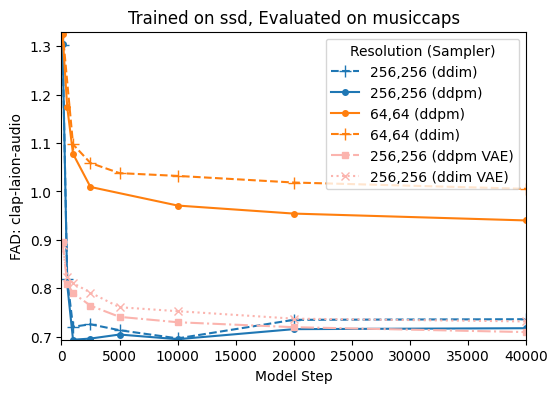

In [73]:
plot_fad_scores_w_vae(concat_df, 'ssd', 'musiccaps', 'clap-laion-audio')

/tmp/ipykernel_2674152/1244241188.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_vae = plt.cm.get_cmap('Pastel1')(np.arange(len(resolutions)))


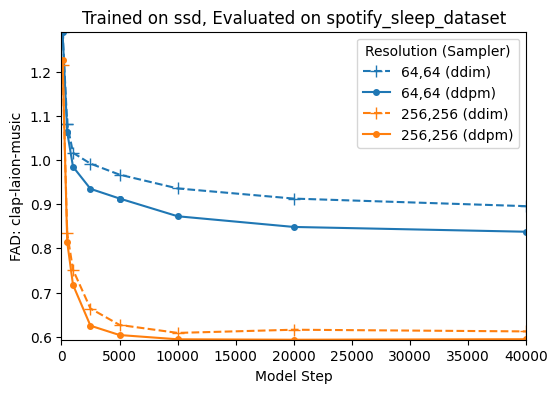

In [79]:
plot_fad_scores_w_vae(concat_df, 'ssd', 'spotify_sleep_dataset', 'clap-laion-music')

/tmp/ipykernel_2674152/1244241188.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_vae = plt.cm.get_cmap('Pastel1')(np.arange(len(resolutions)))


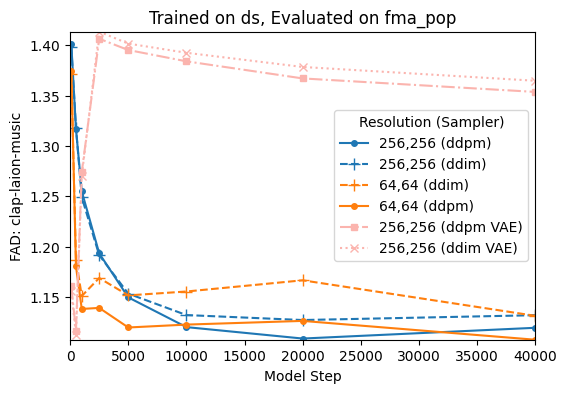

In [78]:
plot_fad_scores_w_vae(concat_df, 'ds', 'fma_pop', 'clap-laion-music')

In [80]:
concat_df

Unnamed: 0     wall_time  step       value dataset resolution  \
0              0  1.716550e+09     0    1.174449      ds    256,256   
1              1  1.716550e+09     0    1.160421      ds    256,256   
2              2  1.716550e+09     0   19.601179      ds    256,256   
3              3  1.716550e+09     0    1.123486      ds    256,256   
4              4  1.716550e+09     0    1.078583      ds    256,256   
...          ...           ...   ...         ...     ...        ...   
1397        1399  1.716266e+09     0    1.278465     ssd    256,256   
1398        1400  1.716266e+09     0   24.246433     ssd    256,256   
1399        1401  1.716267e+09     0  135.416168     ssd    256,256   
1400        1402  1.716267e+09     0  640.542419     ssd    256,256   
1401        1403  1.716267e+09     0   38.720860     ssd    256,256   

      model_step sampler  vae         fad_model reference_dataset  
0            100    ddpm  vae  clap-laion-audio           fma_pop  
1            100    ddpm  vae  clap-laion-music           fma_pop  
2            100    ddpm  vae            vggish           fma_pop  
3            100    ddpm  vae  clap-laion-audio         musiccaps  
4            100    ddpm  vae  clap-laion-music         musiccaps  
...          ...     ...  ...               ...               ...  
1397         100    ddpm  NaN  clap-laion-music         musiccaps  
1398         100    ddpm  NaN            vggish         musiccaps  
1399         100    ddpm  NaN   encodec-emb-48k         musiccaps  
1400         100    ddpm  NaN       encodec-emb         musiccaps  
1401         100    ddpm  NaN       MERT-v1-95M         musiccaps  

[1694 rows x 11 columns]

# Long SSD experiments 

In [28]:
log_dirs = []
for base_model in ['ssd_256_256', 'ssd_512_32', 'ssd_512_64', 'ssd_512_128', 'ssd_64_64', 'ssd_1024_128', 'vae_ssd_256_256', ]:
    for model_step in [40000]:
        for inf_path in ['sch_ddpm_nisteps_1000', 'sch_ddim_nisteps_100']:
            path = f'hpc_tensorboard/models/{base_model}/model_step_{model_step}/samples/{inf_path}'
            log_dirs.append(path)

In [29]:
log_dirs = ["../" + d for d in log_dirs]
log_dirs = [d for d in log_dirs if '/archive' not in d]
log_dirs = [d for d in log_dirs if 'audio' not in d]
ssd_512_32_dirs = [d for d in log_dirs if '512_32' in d]
ssd_512_64_dirs = [d for d in log_dirs if '512_64' in d]
ssd_512_128_dirs = [d for d in log_dirs if '512_128' in d]
ssd_64_64_dirs = [d for d in log_dirs if '64_64' in d]
ssd_256_256_dirs = [d for d in log_dirs if '256_256' in d]
ssd_1024_128_dirs = [d for d in log_dirs if '1024_128' in d]
all_dirs = [ssd_512_32_dirs, ssd_512_64_dirs, ssd_512_128_dirs, ssd_64_64_dirs, ssd_256_256_dirs, ssd_1024_128_dirs]

In [30]:
# Extract scalars from all directories and combine into a single DataFrame
all_scalars = []

for dir_list in all_dirs:
    for log_dir in dir_list:
        print(log_dir)

        scalars = extract_scalars(log_dir)
        for tag, values in scalars.items():
            df = pd.DataFrame(values)
            df['log_dir'] = log_dir
            df['tag'] = tag
            all_scalars.append(df)

# Combine all dataframes
result_df = pd.concat(all_scalars, ignore_index=True)

# Save the DataFrame to a CSV file
result_df.to_csv('long_ssd_scalars_updated.csv', index=False)


../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddim_nisteps_100
../hpc_tensorboard/models/ssd_512_64/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_64/model_step_40000/samples/sch_ddim_nisteps_100
../hpc_tensorboard/models/ssd_512_128/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_128/model_step_40000/samples/sch_ddim_nisteps_100
../hpc_tensorboard/models/ssd_64_64/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_64_64/model_step_40000/samples/sch_ddim_nisteps_100
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddim_nisteps_100
../hpc_tensorboard/models/vae_ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/vae_ssd_256_256/model_step_40000/samples/sch_ddi

In [31]:
result_df['log_dir'][0]

'../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddpm_nisteps_1000'

In [32]:
# Function to extract dataset
def extract_dataset(log_dir):
    return log_dir.split('/')[3].split('_')[0]

# Function to extract resolution
def extract_resolution(log_dir):
    return ','.join(log_dir.split('/')[3].split('_')[1:])

# Function to extract model_step
def extract_model_step(log_dir):
    return log_dir.split('/')[4].split('_')[2]

# Function to extract sampler
def extract_sampler(log_dir):
    return log_dir.split('/')[-1].split('_')[1]

def extract_vae(log_dir):
    return 'vae' in log_dir

def get_inference_time(log_dir):
    print(log_dir)
    
    if  'ddim' in log_dir and 'vae_ssd_256_256' in log_dir: return 0.008
    elif 'ddpm' in log_dir and 'vae_ssd_256_256' in log_dir: return 0.116
    
    elif 'ddim' in log_dir and '64_64' in log_dir: return 0.0743
    elif 'ddpm' in log_dir and '64_64' in log_dir: return 1.162
    
    elif 'ddim' in log_dir and '256_256' in log_dir: return 0.370
    elif 'ddpm' in log_dir and '256_256' in log_dir: return 3.784
    
    elif 'ddim' in log_dir and '512_32' in log_dir: return 0.0474
    elif 'ddpm' in log_dir and '512_32' in log_dir: return 0.528
    
    elif 'ddim' in log_dir and '512_64' in log_dir: return 0.092
    elif 'ddpm' in log_dir and '512_64' in log_dir: return 0.951
    
    elif 'ddim' in log_dir and '512_128' in log_dir: return 0.187
    elif 'ddpm' in log_dir and '512_128' in log_dir: return 1.894
    
    elif 'ddim' in log_dir and '1024_128' in log_dir: return 0.195
    elif 'ddpm' in log_dir and '1024_128' in log_dir: return 1.975


# Apply the functions to create new columns
result_df['dataset'] = result_df['log_dir'].apply(extract_dataset)
result_df['resolution'] = result_df['log_dir'].apply(extract_resolution)
result_df['model_step'] = result_df['log_dir'].apply(extract_model_step)
result_df['sampler'] = result_df['log_dir'].apply(extract_sampler)
result_df['inference_time'] = result_df['log_dir'].apply(get_inference_time)
result_df['vae'] = result_df['log_dir'].apply(extract_vae)

# Function to extract fad_model
def extract_fad_model(tag):
    return tag.split('fad_')[1].split('_ref')[0]

# Function to extract reference_dataset
def extract_reference_dataset(tag):
    return tag.split('_ref_')[1].split('_gen')[0]

# Apply the functions to create new columns
result_df['fad_model'] = result_df['tag'].apply(extract_fad_model)
result_df['reference_dataset'] = result_df['tag'].apply(extract_reference_dataset)

# Drop the original 'log_dir' and 'tag' columns if no longer needed
# result_df.drop(columns=['log_dir', 'tag'], inplace=True)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Cleaned Results DataFrame", dataframe=result_df)


../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddim_nisteps_100
../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddim_nisteps_100
../hpc_tensorboard/models/ssd_512_32/model_step_40000/samples/sch_ddim_nisteps

In [35]:
result_df[result_df['resolution'] == '512,32']

wall_time  step      value  \
0   1.716554e+09     0   0.883853   
1   1.716554e+09     0   0.810608   
2   1.716554e+09     0   7.464810   
3   1.716554e+09     0   0.891958   
4   1.716554e+09     0   0.968335   
5   1.716554e+09     0  10.080668   
6   1.716554e+09     0   0.900143   
7   1.716554e+09     0   0.962323   
8   1.716554e+09     0  16.329153   
9   1.716554e+09     0   0.961064   
10  1.716554e+09     0   0.863341   
11  1.716554e+09     0   8.086961   
12  1.716554e+09     0   0.990072   
13  1.716554e+09     0   1.001055   
14  1.716554e+09     0  10.556540   
15  1.716554e+09     0   0.994371   
16  1.716554e+09     0   0.999789   
17  1.716554e+09     0  17.216454   

                                              log_dir  \
0   ../hpc_tensorboard/models/ssd_512_32/model_ste...   
1   ../hpc_tensorboard/models/ssd_512_32/model_ste...   
2   ../hpc_tensorboard/models/ssd_512_32/model_ste...   
3   ../hpc_tensorboard/models/ssd_512_32/model_ste...   
4   ../hpc_tensorboard/models/ssd_512_32/model_ste...   
5   ../hpc_tensorboard/models/ssd_512_32/model_ste...   
6   ../hpc_tensorboard/models/ssd_512_32/model_ste...   
7   ../hpc_tensorboard/models/ssd_512_32/model_ste...   
8   ../hpc_tensorboard/models/ssd_512_32/model_ste...   
9   ../hpc_tensorboard/models/ssd_512_32/model_ste...   
10  ../hpc_tensorboard/models/ssd_512_32/model_ste...   
11  ../hpc_tensorboard/models/ssd_512_32/model_ste...   
12  ../hpc_tensorboard/models/ssd_512_32/model_ste...   
13  ../hpc_tensorboard/models/ssd_512_32/model_ste...   
14  ../hpc_tensorboard/models/ssd_512_32/model_ste...   
15  ../hpc_tensorboard/models/ssd_512_32/model_ste...   
16  ../hpc_tensorboard/models/ssd_512_32/model_ste...   
17  ../hpc_tensorboard/models/ssd_512_32/model_ste...   

                                                  tag dataset resolution  \
0   fad_clap-laion-audio_ref_spotify_sleep_dataset...     ssd     512,32   
1   fad_clap-laion-music_ref_spotify_sleep_dataset...     ssd     512,32   
2       fad_vggish_ref_spotify_sleep_dataset_gen_None     ssd     512,32   
3           fad_clap-laion-audio_ref_fma_pop_gen_None     ssd     512,32   
4           fad_clap-laion-music_ref_fma_pop_gen_None     ssd     512,32   
5                     fad_vggish_ref_fma_pop_gen_None     ssd     512,32   
6         fad_clap-laion-audio_ref_musiccaps_gen_None     ssd     512,32   
7         fad_clap-laion-music_ref_musiccaps_gen_None     ssd     512,32   
8                   fad_vggish_ref_musiccaps_gen_None     ssd     512,32   
9   fad_clap-laion-audio_ref_spotify_sleep_dataset...     ssd     512,32   
10  fad_clap-laion-music_ref_spotify_sleep_dataset...     ssd     512,32   
11      fad_vggish_ref_spotify_sleep_dataset_gen_None     ssd     512,32   
12          fad_clap-laion-audio_ref_fma_pop_gen_None     ssd     512,32   
13          fad_clap-laion-music_ref_fma_pop_gen_None     ssd     512,32   
14                    fad_vggish_ref_fma_pop_gen_None     ssd     512,32   
15        fad_clap-laion-audio_ref_musiccaps_gen_None     ssd     512,32   
16        fad_clap-laion-music_ref_musiccaps_gen_None     ssd     512,32   
17                  fad_vggish_ref_musiccaps_gen_None     ssd     512,32   

   model_step sampler  inference_time    vae         fad_model  \
0       40000    ddpm          0.5280  False  clap-laion-audio   
1       40000    ddpm          0.5280  False  clap-laion-music   
2       40000    ddpm          0.5280  False            vggish   
3       40000    ddpm          0.5280  False  clap-laion-audio   
4       40000    ddpm          0.5280  False  clap-laion-music   
5       40000    ddpm          0.5280  False            vggish   
6       40000    ddpm          0.5280  False  clap-laion-audio   
7       40000    ddpm          0.5280  False  clap-laion-music   
8       40000    ddpm          0.5280  False            vggish   
9       40000    ddim          0.0474  False  clap-laion-audio   
10      40000    ddim          0.0474  False  cl

In [33]:
result_df.to_csv('../results/long_ssd_updated.csv')

In [18]:
result_df = pd.read_csv('../results/long_ssd_updated.csv')

In [24]:
plot_filtered_data(result_df, 'ssd', 'clap-laion-audio')

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp44nyhry7 8af3bffe93fadfc1f49b7aebd18564cf.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./8af3bffe93fadfc1f49b7aebd18564cf.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp44nyhry7/8af3bffe93fadfc1f49b7aebd18564cf.log.




<Figure size 1000x600 with 1 Axes>

In [ ]:
# CHANGE THIS TO AVERAGE DISTANCE BETWEEN THE SCORES FOR EACH MODEL, RATHER THAN ABSOLUTE VALUE COMPARISON, to get a more comprehensive look over the different runs?

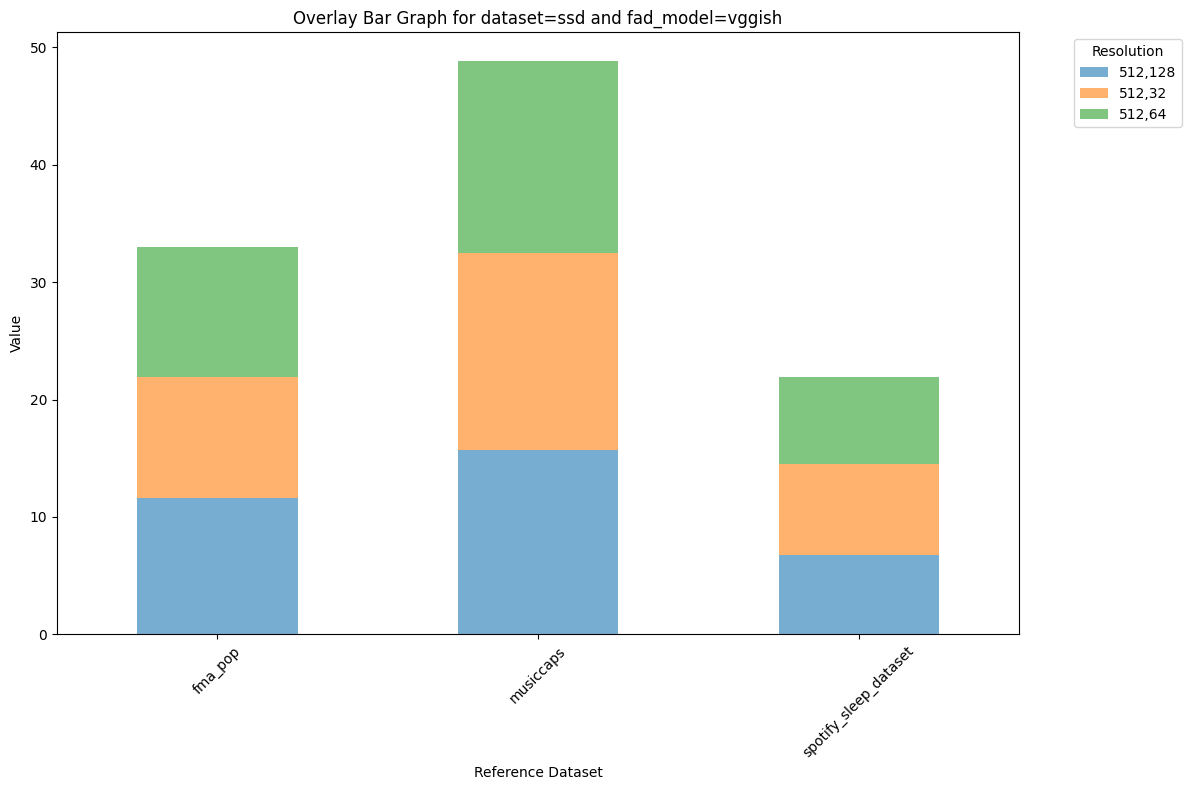

In [118]:
plot_bar_graph(result_df, 'ssd', 'vggish')

In [14]:
result_df.to_csv('../results/long_ssd_results.csv')

# Inference/Training Time vs FAD score

In [ ]:
# we want real time inference being taken into account

# Selected Non-Noisy Samples

In [38]:
log_dirs = [
    "../hpc_tensorboard/models/ssd_512_128/model_step_40000/samples/sch_ddim_nisteps_100",
    "../hpc_tensorboard/models/ssd_512_128/model_step_40000/samples/sch_ddim_nisteps_100_selected",
    "../hpc_tensorboard/models/ssd_512_128/model_step_40000/samples/sch_ddpm_nisteps_1000",
    "../hpc_tensorboard/models/ssd_512_128/model_step_40000/samples/sch_ddpm_nisteps_1000_selected",
    
    "../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddim_nisteps_100",
    "../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddim_nisteps_100_selected",
    "../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000",
    "../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000_selected"
]

In [39]:
# Extract scalars from all directories and combine into a single DataFrame
all_scalars = []

for log_dir in log_dirs:
    print(log_dir)
    scalars = extract_scalars(log_dir)
    for tag, values in scalars.items():
        df = pd.DataFrame(values)
        df['log_dir'] = log_dir
        df['tag'] = tag
        all_scalars.append(df)

# Combine all dataframes
result_df = pd.concat(all_scalars, ignore_index=True)

# Save the DataFrame to a CSV file
result_df.to_csv('selected_scalars.csv', index=False)


../hpc_tensorboard/models/ssd_512_128/model_step_40000/samples/sch_ddim_nisteps_100
../hpc_tensorboard/models/ssd_512_128/model_step_40000/samples/sch_ddim_nisteps_100_selected
../hpc_tensorboard/models/ssd_512_128/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_512_128/model_step_40000/samples/sch_ddpm_nisteps_1000_selected
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddim_nisteps_100
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddim_nisteps_100_selected
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000_selected


In [40]:
result_df

wall_time  step      value  \
0   1.716554e+09     0   0.657153   
1   1.716554e+09     0   0.608632   
2   1.716554e+09     0   6.279850   
3   1.716554e+09     0   0.774109   
4   1.716554e+09     0   0.823027   
..           ...   ...        ...   
85  1.717079e+09     0   0.859856   
86  1.717079e+09     0  11.014889   
87  1.717080e+09     0   0.670229   
88  1.717080e+09     0   0.865207   
89  1.717080e+09     0  16.309038   

                                              log_dir  \
0   ../hpc_tensorboard/models/ssd_512_128/model_st...   
1   ../hpc_tensorboard/models/ssd_512_128/model_st...   
2   ../hpc_tensorboard/models/ssd_512_128/model_st...   
3   ../hpc_tensorboard/models/ssd_512_128/model_st...   
4   ../hpc_tensorboard/models/ssd_512_128/model_st...   
..                                                ...   
85  ../hpc_tensorboard/models/ssd_256_256/model_st...   
86  ../hpc_tensorboard/models/ssd_256_256/model_st...   
87  ../hpc_tensorboard/models/ssd_256_256/model_st...   
88  ../hpc_tensorboard/models/ssd_256_256/model_st...   
89  ../hpc_tensorboard/models/ssd_256_256/model_st...   

                                                  tag  
0   fad_clap-laion-audio_ref_spotify_sleep_dataset...  
1   fad_clap-laion-music_ref_spotify_sleep_dataset...  
2       fad_vggish_ref_spotify_sleep_dataset_gen_None  
3           fad_clap-laion-audio_ref_fma_pop_gen_None  
4           fad_clap-laion-music_ref_fma_pop_gen_None  
..                                                ...  
85          fad_clap-laion-music_ref_fma_pop_gen_None  
86                    fad_vggish_ref_fma_pop_gen_None  
87        fad_clap-laion-audio_ref_musiccaps_gen_None  
88        fad_clap-laion-music_ref_musiccaps_gen_None  
89                  fad_vggish_ref_musiccaps_gen_None  

[90 rows x 5 columns]

In [23]:
result_df['log_dir'][29]

'../hpc_tensorboard/models/ssd_512_128/model_step_40000/samples/sch_ddpm_nisteps_1000_selected'

In [41]:
# Function to extract dataset
def extract_dataset(log_dir):
    return log_dir.split('/')[3].split('_')[0]

# Function to extract resolution
def extract_resolution(log_dir):
    return ','.join(log_dir.split('/')[3].split('_')[1:])

# Function to extract model_step
def extract_model_step(log_dir):
    return log_dir.split('/')[4].split('_')[2]

# Function to extract sampler
def extract_sampler(log_dir):
    return log_dir.split('/')[-1].split('_')[1]

# extract selected
def extract_selected(log_dir):
    return 'selected' in log_dir.split('/')[-1]

# Apply the functions to create new columns
result_df['dataset'] = result_df['log_dir'].apply(extract_dataset)
result_df['resolution'] = result_df['log_dir'].apply(extract_resolution)
result_df['model_step'] = result_df['log_dir'].apply(extract_model_step)
result_df['sampler'] = result_df['log_dir'].apply(extract_sampler)
result_df['selected'] = result_df['log_dir'].apply(extract_selected)

# Function to extract fad_model
def extract_fad_model(tag):
    return tag.split('fad_')[1].split('_ref')[0]

# Function to extract reference_dataset
def extract_reference_dataset(tag):
    return tag.split('_ref_')[1].split('_gen')[0]

# Apply the functions to create new columns
result_df['fad_model'] = result_df['tag'].apply(extract_fad_model)
result_df['reference_dataset'] = result_df['tag'].apply(extract_reference_dataset)

# Drop the original 'log_dir' and 'tag' columns if no longer needed
result_df.drop(columns=['log_dir', 'tag'], inplace=True)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Cleaned Results DataFrame", dataframe=result_df)

In [45]:
result_df = result_df[result_df['fad_model'].isin(['clap-laion-audio', 'clap-laion-music', 'vggish'])]

In [50]:
result_df.to_csv('../results/selected_noise_level_results.csv')

In [53]:
result_df[result_df['resolution'] == '256,256']

wall_time  step      value dataset resolution model_step sampler  \
36  1.716266e+09     0   0.624939     ssd    256,256      40000    ddim   
37  1.716266e+09     0   0.611860     ssd    256,256      40000    ddim   
38  1.716266e+09     0   5.787899     ssd    256,256      40000    ddim   
42  1.716266e+09     0   0.764739     ssd    256,256      40000    ddim   
43  1.716266e+09     0   0.848486     ssd    256,256      40000    ddim   
44  1.716266e+09     0  11.159650     ssd    256,256      40000    ddim   
48  1.716267e+09     0   0.735829     ssd    256,256      40000    ddim   
49  1.716267e+09     0   0.848345     ssd    256,256      40000    ddim   
50  1.716267e+09     0  15.183124     ssd    256,256      40000    ddim   
54  1.717079e+09     0   0.575088     ssd    256,256      40000    ddim   
55  1.717079e+09     0   0.592638     ssd    256,256      40000    ddim   
56  1.717079e+09     0   5.021101     ssd    256,256      40000    ddim   
57  1.717079e+09     0   0.743062     ssd    256,256      40000    ddim   
58  1.717079e+09     0   0.872095     ssd    256,256      40000    ddim   
59  1.717079e+09     0  11.163731     ssd    256,256      40000    ddim   
60  1.717080e+09     0   0.709505     ssd    256,256      40000    ddim   
61  1.717080e+09     0   0.894959     ssd    256,256      40000    ddim   
62  1.717080e+09     0  16.582802     ssd    256,256      40000    ddim   
63  1.716266e+09     0   0.589961     ssd    256,256      40000    ddpm   
64  1.716266e+09     0   0.594222     ssd    256,256      40000    ddpm   
65  1.716266e+09     0   6.104685     ssd    256,256      40000    ddpm   
69  1.716266e+09     0   0.755986     ssd    256,256      40000    ddpm   
70  1.716266e+09     0   0.846255     ssd    256,256      40000    ddpm   
71  1.716266e+09     0  11.860357     ssd    256,256      40000    ddpm   
75  1.716267e+09     0   0.717218     ssd    256,256      40000    ddpm   
76  1.716267e+09     0   0.818793     ssd    256,256      40000    ddpm   
77  1.716267e+09     0  15.814582     ssd    256,256      40000    ddpm   
81  1.717079e+09     0   0.536265     ssd    256,256      40000    ddpm   
82  1.717079e+09     0   0.568122     ssd    256,256      40000    ddpm   
83  1.717079e+09     0   4.900670     ssd    256,256      40000    ddpm   
84  1.717079e+09     0   0.711788     ssd    256,256      40000    ddpm   
85  1.717079e+09     0   0.859856     ssd    256,256      40000    ddpm   
86  1.717079e+09     0  11.014889     ssd    256,256      40000    ddpm   
87  1.717080e+09     0   0.670229     ssd    256,256      40000    ddpm   
88  1.717080e+09     0   0.865207     ssd    256,256      40000    ddpm   
89  1.717080e+09     0  16.309038     ssd    256,256      40000    ddpm   

    selected         fad_model      reference_dataset  
36     False  clap-laion-audio  spotify_sleep_dataset  
37     False  clap-laion-music  spotify_sleep_dataset  
38     False            vggish  spotify_sleep_dataset  
42     False  clap-laion-audio                fma_pop  
43     False  clap-laion-music                fma_pop  
44     False            vggish                fma_pop  
48     False  clap-laion-audio              musiccaps  
49     False  clap-laion-music              musiccaps  
50     False            vggish              musiccaps  
54      True  clap-laion-audio  spotify_sleep_dataset  
55      True  clap-laion-music  spotify_sleep_dataset  
56      True            vggish  spotify_sleep_dataset  
57      True  clap-laion-audio                fma_pop  
58      True  clap-laion-music                fma_pop  
59      True            vggish                fma_pop  
60      True  clap-laion-audio              musiccaps  
61      True  clap-laion-music              musiccaps  
62      True            vggish              musiccaps  
63     False  clap-laion-audio  spotify_sleep_dataset  
64     False  clap-laion-music  spotify_sleep_dataset  
65     False            vggish  spotify_sleep_dataset  

# Load FAD Compute Experiments


In [1]:
# Suffixes for directories containing 'sch_ddpm_nisteps_1000'
sch_ddpm_nisteps_1000_suffixes = [
    '',
    '102',
    '204',
    '409',
    '1024',
    '51',
    '1228',
    '1433',
    '614',
    '819',
    '1638',
    '1843'
]

# Suffixes for directories containing 'sch_ddim_nisteps_100'
sch_ddim_nisteps_100_suffixes = [
    '',
    '102',
    '204',
    '409',
    '51',
    '1024',
    '1228',
    '1433',
    '1638',
    '1843',
    '614',
    '819'
]

# Suffixes for directories containing 'sch_ddpm_nisteps_1000'
sch_ddpm_nisteps_1000_suffixes2 = [
    '',
    '40',
    '80',
    '160',
    '320',
    '480',
    '640',
    '800',
    '960',
    '1120',
    '1280',
    '1440'
]

# Suffixes for directories containing 'sch_ddim_nisteps_100'
sch_ddim_nisteps_100_suffixes2 = [
    '',
    '51',
    '102',
    '204',
    '409',
    '614',
    '819',
    '1024',
    '1228',
    '1433',
    '1638',
    '1843'
]



In [2]:
suffixes = set(
    sch_ddpm_nisteps_1000_suffixes +
    sch_ddim_nisteps_100_suffixes +
    sch_ddpm_nisteps_1000_suffixes2 +
    sch_ddim_nisteps_100_suffixes2
)

# Convert the set back to a list (optional, if you need a list)
unique_suffixes = list(suffixes)

In [3]:
import os

log_dirs = []
for base_model in ['ssd_256_256', 'ssd_64_64']:
    for model_step in [40000]:
        for inf_path in ['sch_ddpm_nisteps_1000', 'sch_ddim_nisteps_100']:
            for suffix in unique_suffixes:
                # if suffix == '':
                #     suffix = 1600 if base_model == 'ssd_256' and inf_path == 'sch_ddpm_nisteps_1000' else 2048
                ending = f"{inf_path}_{suffix}" if suffix else inf_path

                path = f'../hpc_tensorboard/models/{base_model}/model_step_{model_step}/samples/{ending}'
                
                if os.path.exists(path):
                    log_dirs.append(path)


In [4]:
log_dirs

['../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000',
 '../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000_1440',
 '../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000_160',
 '../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000_80',
 '../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000_1280',
 '../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000_480',
 '../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000_40',
 '../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000_1120',
 '../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000_800',
 '../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000_320',
 '../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm

In [14]:
# Extract scalars from all directories and combine into a single DataFrame
all_scalars = []

for log_dir in log_dirs:
    scalars = extract_scalars(log_dir)
    for tag, values in scalars.items():
        df = pd.DataFrame(values)
        df['log_dir'] = log_dir
        df['tag'] = tag
        all_scalars.append(df)

# Combine all dataframes
result_df = pd.concat(all_scalars, ignore_index=True)

# Save the DataFrame to a CSV file
result_df.to_csv('fad_compute_scalars.csv', index=False)

2024-06-01 13:38:24.469821: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-01 13:38:28.727602: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
# Function to extract dataset
def extract_dataset(log_dir):
    if 'vae' not in log_dir:
        return log_dir.split('/')[3].split('_')[0]
    else:
        return log_dir.split('/')[3].split('_')[1]

# Function to extract resolution
def extract_resolution(log_dir):
    return ','.join(log_dir.split('/')[3].split('_')[2:])

# Function to extract model_step
def extract_model_step(log_dir):
    return log_dir.split('/')[4].split('_')[2]

# Function to extract sampler
def extract_sampler(log_dir):
    return log_dir.split('/')[-1].split('_')[1]

# Function to extract num samples
def extract_num_samples(log_dir):
    print(f'-------------')
    print(log_dir)
    print(log_dir.split('/')[-1].split('_'))
    print(log_dir.split('/')[-1].split('_')[-1])
    if len(log_dir.split('/')[-1].split('_')) == 4:
        if '256_256' in log_dir and 'sch_ddpm' in log_dir:
            return 1600
        else:
            return 2048
    else:
        return log_dir.split('/')[-1].split('_')[-1]
        

# Function to extract sampler
def extract_vae(log_dir):
    if 'vae' in log_dir:
        return log_dir.split('/')[3].split('_')[0]
    else:
        return None


# Apply the functions to create new columns
result_df['dataset'] = result_df['log_dir'].apply(extract_dataset)
result_df['resolution'] = result_df['log_dir'].apply(extract_resolution)
result_df['model_step'] = result_df['log_dir'].apply(extract_model_step)
result_df['sampler'] = result_df['log_dir'].apply(extract_sampler)
result_df['vae'] = result_df['log_dir'].apply(extract_vae)
result_df['num_fad_samples'] = result_df['log_dir'].apply(extract_num_samples)

# Function to extract fad_model
def extract_fad_model(tag):
    return tag.split('fad_')[1].split('_ref')[0]

# Function to extract reference_dataset
def extract_reference_dataset(tag):
    return tag.split('_ref_')[1].split('_gen')[0]

# Apply the functions to create new columns
result_df['fad_model'] = result_df['tag'].apply(extract_fad_model)
result_df['reference_dataset'] = result_df['tag'].apply(extract_reference_dataset)

# Drop the original 'log_dir' and 'tag' columns if no longer needed
result_df.drop(columns=['log_dir', 'tag'], inplace=True)

# import ace_tools as tools; tools.display_dataframe_to_user(name="Cleaned Results DataFrame", dataframe=result_df)


-------------
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000
['sch', 'ddpm', 'nisteps', '1000']
1000
-------------
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000
['sch', 'ddpm', 'nisteps', '1000']
1000
-------------
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000
['sch', 'ddpm', 'nisteps', '1000']
1000
-------------
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000
['sch', 'ddpm', 'nisteps', '1000']
1000
-------------
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000
['sch', 'ddpm', 'nisteps', '1000']
1000
-------------
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000
['sch', 'ddpm', 'nisteps', '1000']
1000
-------------
../hpc_tensorboard/models/ssd_256_256/model_step_40000/samples/sch_ddpm_nisteps_1000
['sch', 'ddpm', 'nisteps', '1000']
1000
-------------
../hpc_tensor

In [16]:
result_df

wall_time  step       value dataset resolution model_step sampler  \
0    1.716266e+09     0    0.589961     ssd        256      40000    ddpm   
1    1.716266e+09     0    0.594222     ssd        256      40000    ddpm   
2    1.716266e+09     0    6.104685     ssd        256      40000    ddpm   
3    1.716266e+09     0   23.567801     ssd        256      40000    ddpm   
4    1.716266e+09     0  130.400467     ssd        256      40000    ddpm   
..            ...   ...         ...     ...        ...        ...     ...   
391  1.716686e+09     0    0.898424     ssd         64      40000    ddim   
392  1.716686e+09     0    1.029789     ssd         64      40000    ddim   
393  1.716686e+09     0    1.047556     ssd         64      40000    ddim   
394  1.716686e+09     0    1.006626     ssd         64      40000    ddim   
395  1.716686e+09     0    1.074790     ssd         64      40000    ddim   

      vae num_fad_samples         fad_model      reference_dataset  
0    None            1600  clap-laion-audio  spotify_sleep_dataset  
1    None            1600  clap-laion-music  spotify_sleep_dataset  
2    None            1600            vggish  spotify_sleep_dataset  
3    None            1600   encodec-emb-48k  spotify_sleep_dataset  
4    None            1600       encodec-emb  spotify_sleep_dataset  
..    ...             ...               ...                    ...  
391  None            1638  clap-laion-music  spotify_sleep_dataset  
392  None            1638  clap-laion-audio                fma_pop  
393  None            1638  clap-laion-music                fma_pop  
394  None            1638  clap-laion-audio              musiccaps  
395  None            1638  clap-laion-music              musiccaps  

[396 rows x 11 columns]

In [17]:
result_df['num_fad_samples'] = result_df['num_fad_samples'].astype(int)

In [18]:
result_df.to_csv('../results/fad_samples_results.csv')

In [25]:
plot_fad_samples(result_df, 'ssd')

/tmp/ipykernel_128190/1132252065.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', len(df['resolution'].unique()))


IndexError: index 3 is out of bounds for axis 1 with size 3

Error in callback <function _draw_all_if_interactive at 0x723bc9f5a200> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpp9gn4n2z 8af3bffe93fadfc1f49b7aebd18564cf.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./8af3bffe93fadfc1f49b7aebd18564cf.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmpp9gn4n2z/8af3bffe93fadfc1f49b7aebd18564cf.log.




RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp5bqt800e 8af3bffe93fadfc1f49b7aebd18564cf.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./8af3bffe93fadfc1f49b7aebd18564cf.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp5bqt800e/8af3bffe93fadfc1f49b7aebd18564cf.log.




<Figure size 1800x1800 with 9 Axes>

/tmp/ipykernel_1044190/4137048193.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', len(resolutions))


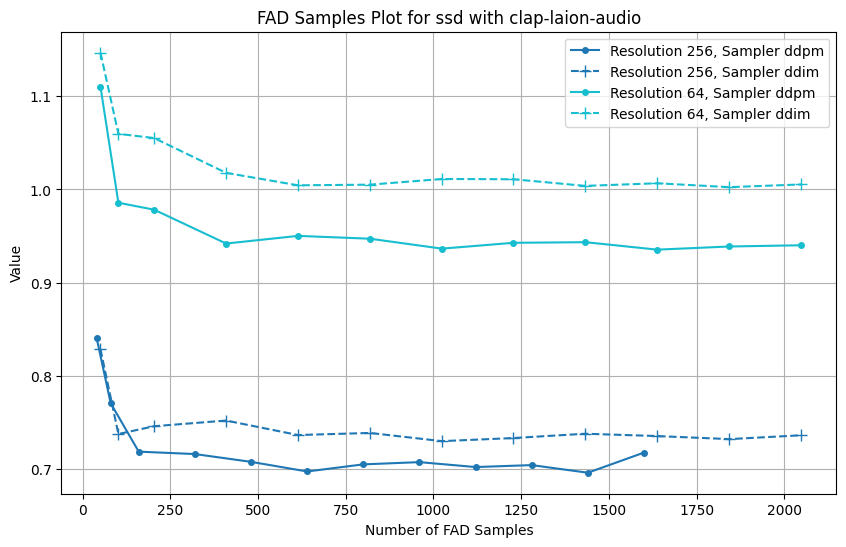

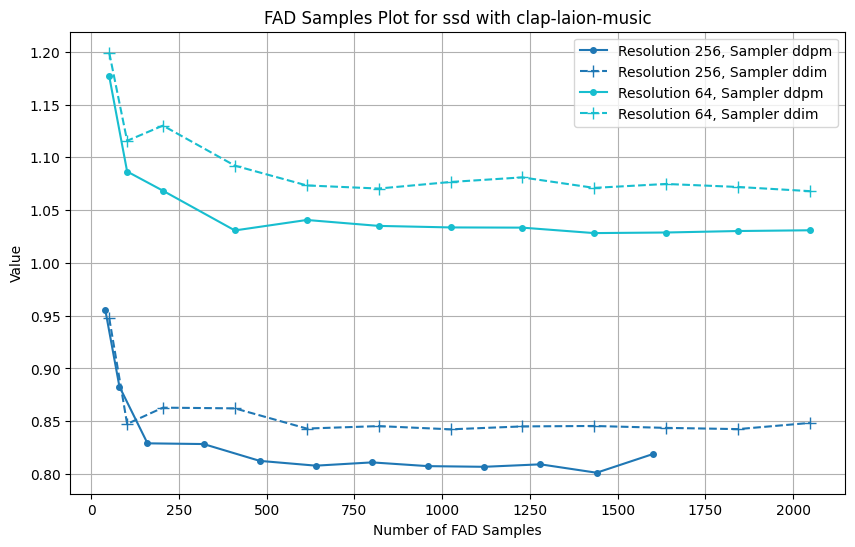

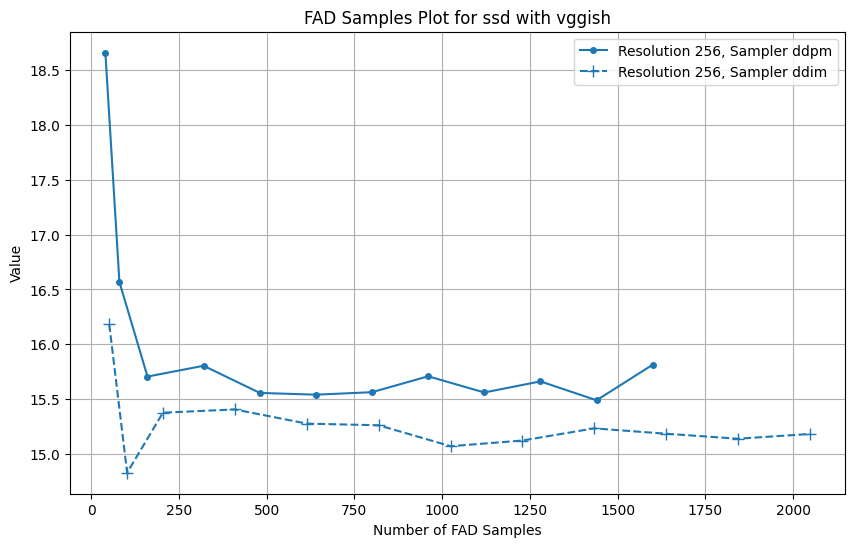

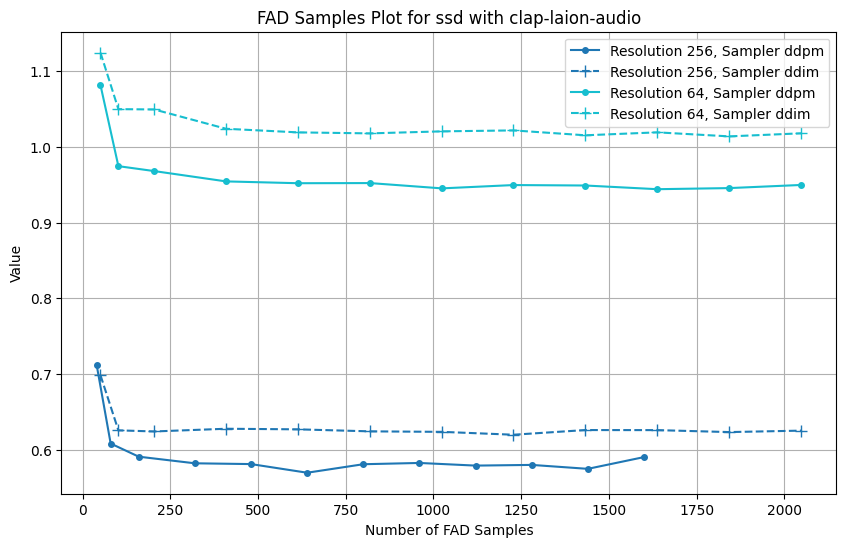

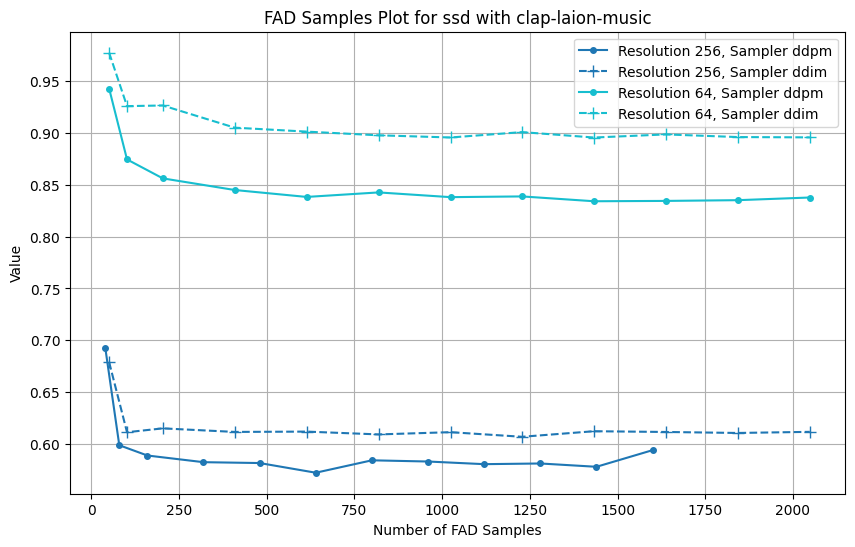

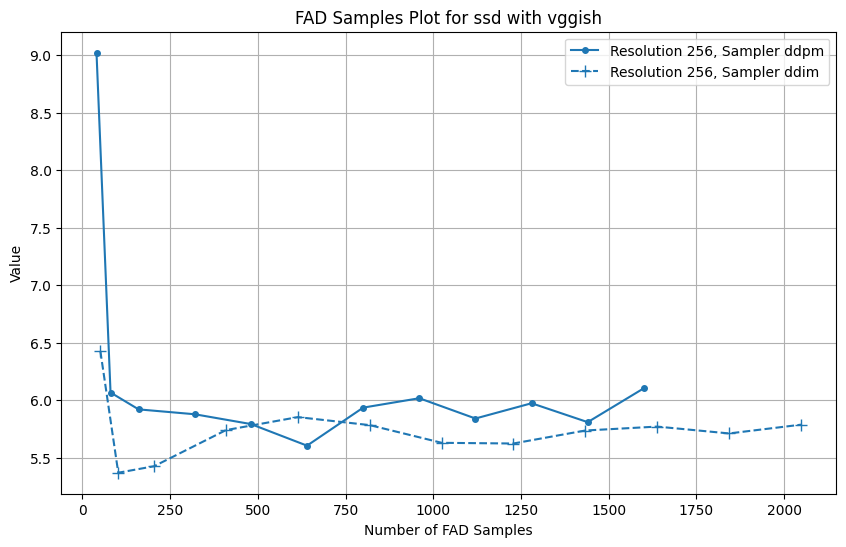

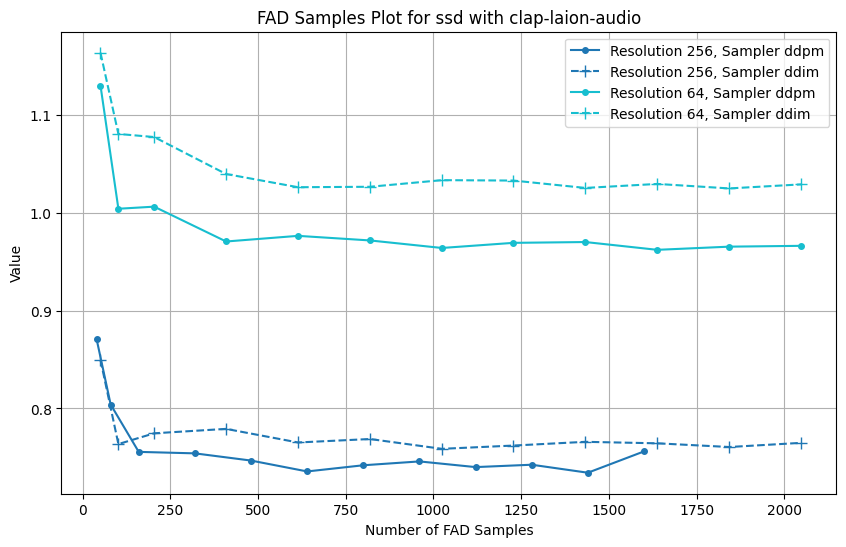

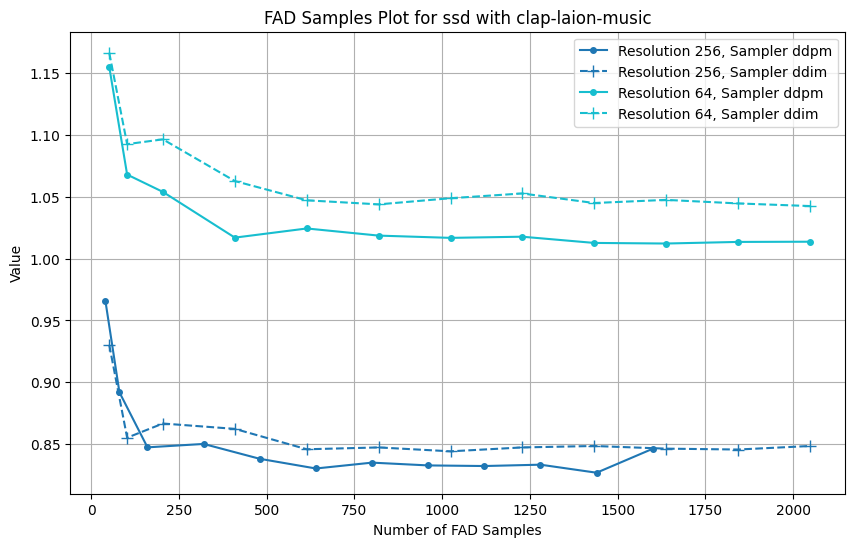

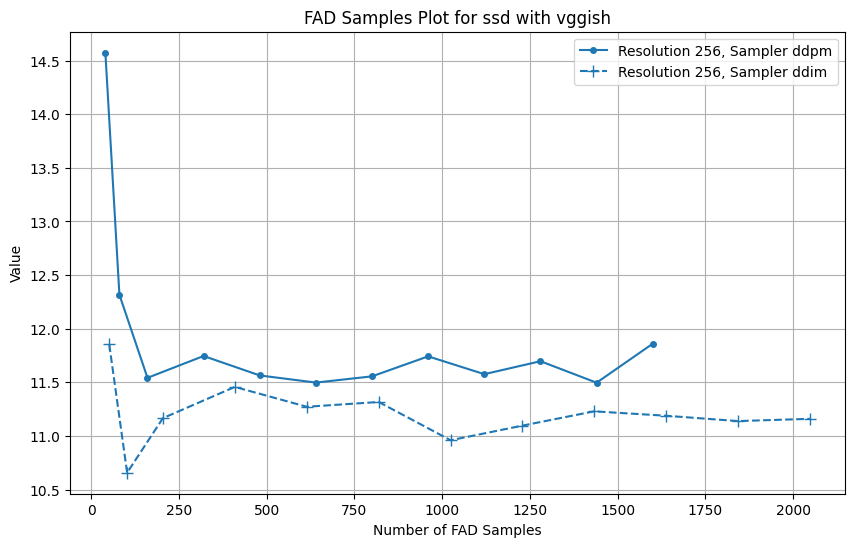

In [88]:
for ref_dataset in ['musiccaps', 'spotify_sleep_dataset', 'fma_pop']:
    for model in ['clap-laion-audio', 'clap-laion-music', 'vggish']:
        plot_fad_samples(result_df, 'ssd', ref_dataset, model)

/tmp/ipykernel_1044190/3019857737.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', len(resolutions))


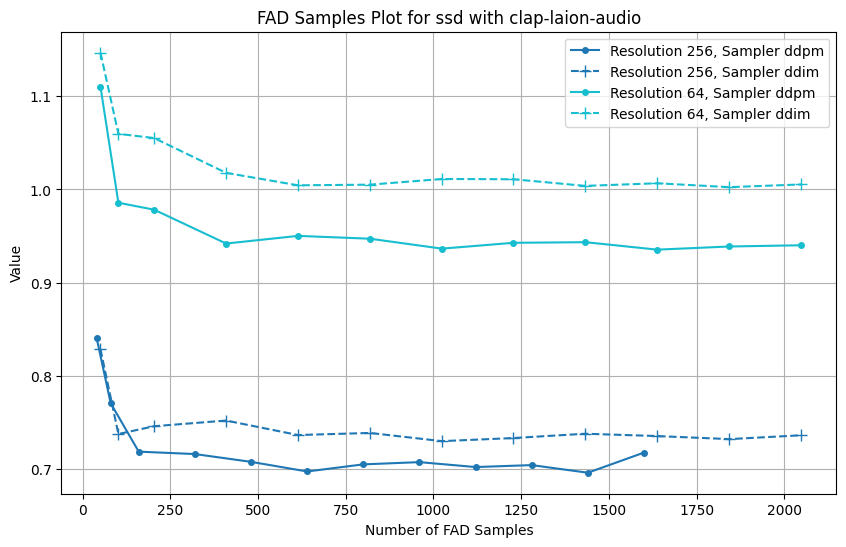

In [83]:
plot_fad_samples(result_df, 'ssd', 'musiccaps', 'clap-laion-audio')

/tmp/ipykernel_1044190/3019857737.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', len(resolutions))


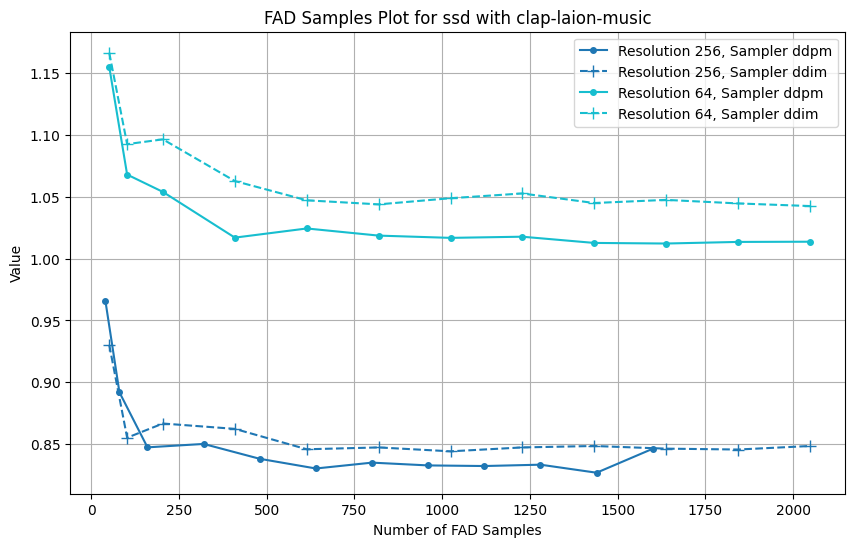

In [82]:
plot_fad_samples(result_df, 'ssd', 'fma_pop', 'clap-laion-music')

In [5]:
import pickle
import torch

# Load the .pkl file
file_path = '../cache/spotify_sleep_dataset/encodings.pkl'

with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Assuming the data is a dictionary of tensors
for d in data:
    print(d.shape)
    break


(1, 512)


In [6]:
# Install necessary libraries
!pip install transformers

import torch
from transformers import T5EncoderModel, T5Tokenizer
import os

# Load the T5 encoder model
model_name = "t5-small"
model = T5EncoderModel.from_pretrained(model_name)
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Calculate the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

# Save the model to a temporary file to calculate its size
model.save_pretrained("./temp_model")
model_size = sum(os.path.getsize(os.path.join("./temp_model", f)) for f in os.listdir("./temp_model"))
model_size_mb = model_size / (1024 * 1024)
print(f"Model size: {model_size_mb:.2f} MB")

# Cleanup the temporary model files
import shutil
shutil.rmtree("./temp_model")


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Number of parameters: 35330816
Model size: 134.78 MB


# Plot losses

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss_curve(df):
    # Ensure the dataframe has the necessary columns
    if not all(col in df.columns for col in ['Wall time', 'Step', 'Value']):
        raise ValueError("DataFrame must contain 'Wall Time', 'Step', and 'Value' columns")

    # Plot the original loss curve in light blue
    plt.figure(figsize=(12, 6))
    plt.plot(df['Step'], df['Value'], color='lightblue', label='Original Loss Curve')

    # Calculate the smoothed version using a simple moving average
    window_size = 10  # This can be adjusted based on the desired smoothness
    df['Smoothed Value'] = df['Value'].rolling(window=window_size).mean()

    # Plot the smoothed loss curve in normal blue
    plt.plot(df['Step'], df['Smoothed Value'], color='blue', label='Smoothed Loss Curve')

    # Adding titles and labels
    plt.title('Training Loss Curve')
    plt.xlabel('Step')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.grid(True)

    # Calculate the 98th percentile value for the y-axis limit
    y_max = df['Value'].quantile(0.98)
    plt.ylim(bottom=0, top=y_max)

    # Show the plot
    plt.show()

# Example usage:
# Assuming you have a DataFrame df with the appropriate columns
# plot_loss_curve(df)


In [30]:
df = pd.read_csv('../results/models_ssd_256_256_logs_train_unet.csv')

In [31]:
df

Wall time   Step     Value
0    1.715830e+09     19  0.851802
1    1.715830e+09     63  0.073511
2    1.715830e+09    108  0.054973
3    1.715831e+09    173  0.046182
4    1.715831e+09    245  0.048564
..            ...    ...       ...
995  1.715877e+09  39916  0.024810
996  1.715877e+09  39940  0.017617
997  1.715877e+09  39986  0.017467
998  1.715877e+09  39994  0.021818
999  1.715877e+09  40000  0.018693

[1000 rows x 3 columns]

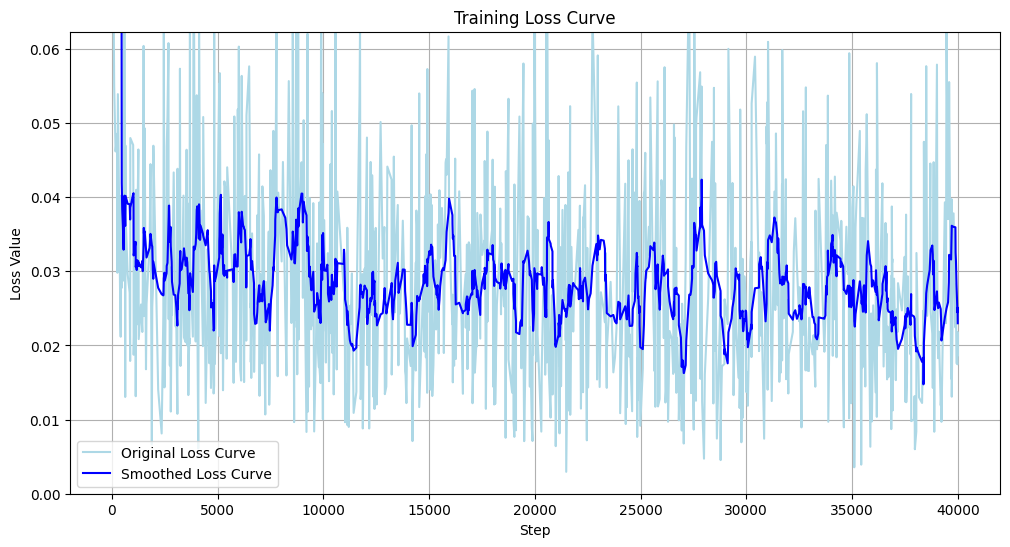

In [32]:
plot_loss_curve(df)

# Calculating Spread of Each Distribution

In [7]:
import numpy as np
import pandas as pd

# Define the list of datasets and models
datasets = [
    ('spotify_sleep_dataset', 'waveform'),
    ('fma_pop', 'waveform'),
    ('drum_samples', 'waveform'),
    ('musiccaps', 'waveform')
]

models = ['vggish', 'clap-laion-audio', 'clap-laion-music']

# Initialize an empty list to store the results
results = []

for dataset, feature_type in datasets:
    for model in models:
        mean_file = f'../stats_from_hpc/{dataset}/{feature_type}/stats/{model}/mu.npy'
        cov_file = f'../stats_from_hpc/{dataset}/{feature_type}/stats/{model}/cov.npy'
        
        try:
            mean_vector = np.load(mean_file)
            cov_matrix = np.load(cov_file)
            
            # Calculate the overall spread characteristics
            eigenvalues = np.linalg.eigvals(cov_matrix)
            volume = np.sqrt(np.linalg.det(cov_matrix))
            trace = np.trace(cov_matrix)
            
            # Store the results in the list
            results.append({
                'dataset': dataset,
                # 'feature_type': feature_type,
                'model': model,
                # 'eigenvalues': eigenvalues,
                # 'volume': volume,
                'trace': trace
            })
        
        except Exception as e:
            print(f"Error processing {dataset}, {feature_type}, {model}: {e}")

# Convert the results into a DataFrame
df = pd.DataFrame(results)


In [8]:
df

dataset             model      trace
0   spotify_sleep_dataset            vggish   9.358106
1   spotify_sleep_dataset  clap-laion-audio   0.573894
2   spotify_sleep_dataset  clap-laion-music   0.501345
3                 fma_pop            vggish  12.961600
4                 fma_pop  clap-laion-audio   0.734825
5                 fma_pop  clap-laion-music   0.789479
6            drum_samples            vggish   5.084578
7            drum_samples  clap-laion-audio   0.457986
8            drum_samples  clap-laion-music   0.462441
9               musiccaps            vggish  19.674353
10              musiccaps  clap-laion-audio   0.768335
11              musiccaps  clap-laion-music   0.755160

In [7]:
import os
from pydub import AudioSegment

def calculate_total_audio_length(directory):
    total_length_ms = 0

    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.wav', '.mp3')):
                print(file)
                file_path = os.path.join(root, file)
                audio = AudioSegment.from_file(file_path)
                total_length_ms += len(audio)

    total_length_hours = total_length_ms / (1000 * 60 * 60)
    return total_length_hours

# Example usage:
directory = "../cache/drum_samples/waveform/"
total_length_hours = calculate_total_audio_length(directory)
print(f"Total length of audio files: {total_length_hours:.2f} hours")


sample_698.wav
sample_51.wav
sample_80.wav
sample_228.wav
sample_4.wav


/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'ffprobe'

In [5]:
!pip install pydub


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


# Filter Noisy Samples for Strong Ones

In [26]:
import os
import numpy as np
import librosa
import librosa.display
from tqdm.notebook import tqdm
import pandas as pd

def is_noisy(file_path, noise_threshold):
    y, sr = librosa.load(file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # Calculate the noise level
    noise_level = np.mean(S_dB)
    
    # Determine if the file is noisy based on the noise threshold
    is_noisy = noise_level > noise_threshold
    
    return is_noisy, noise_level

def filter_noisy_files(directory, noise_threshold):
    """
    Filters out noisy .wav files in a given directory and records noise levels.

    Parameters:
    directory (str): The path to the directory containing .wav files.
    noise_threshold (float): The noise threshold. Files with a mean mel spectrogram density above this value are considered noisy.

    Returns:
    DataFrame: A DataFrame with file paths and their noise levels.
    """
    data = []

    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            is_noisy_file, noise_level = is_noisy(file_path, noise_threshold)
            data.append({'file_path': file_path, 'noise_level': noise_level, 'is_noisy': is_noisy_file})

    df = pd.DataFrame(data)
    return df


In [28]:
import os
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import pandas as pd

def calculate_noise_level(file_path):
    y, sr = librosa.load(file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # Calculate the noise level
    noise_level = np.mean(S_dB)
    
    return noise_level

def process_files(directory):
    """
    Processes .wav files in a given directory and records their noise levels.

    Parameters:
    directory (str): The path to the directory containing .wav files.

    Returns:
    DataFrame: A DataFrame with file paths and their noise levels.
    """
    data = []

    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            noise_level = calculate_noise_level(file_path)
            data.append({'file_path': file_path, 'noise_level': noise_level})

    df = pd.DataFrame(data)
    return df

In [29]:
# Define directories to process
directories = [
    '../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000',
    '../models/ssd_256_256/model_step_40000/samples/audio/sch_ddim_nisteps_100'
]

all_data = []

# Process each directory and collect results
for directory in directories:
    df = process_files(directory)
    all_data.append(df)

# Concatenate all data into a single DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# Display the DataFrame
final_df

  0%|          | 0/1603 [00:00<?, ?it/s]

100%|██████████| 2051/2051 [00:38<00:00, 52.74it/s]


file_path  noise_level
0     ../models/ssd_256_256/model_step_40000/samples...   -31.145237
1     ../models/ssd_256_256/model_step_40000/samples...   -49.920723
2     ../models/ssd_256_256/model_step_40000/samples...   -23.878395
3     ../models/ssd_256_256/model_step_40000/samples...   -54.079487
4     ../models/ssd_256_256/model_step_40000/samples...   -41.731911
...                                                 ...          ...
3643  ../models/ssd_256_256/model_step_40000/samples...   -53.294174
3644  ../models/ssd_256_256/model_step_40000/samples...   -28.178940
3645  ../models/ssd_256_256/model_step_40000/samples...   -48.791592
3646  ../models/ssd_256_256/model_step_40000/samples...   -47.303078
3647  ../models/ssd_256_256/model_step_40000/samples...   -26.649940

[3648 rows x 2 columns]

In [30]:
final_df['file_path'][0]

'../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000/audio_219.wav'

In [31]:
final_df.to_csv('../results/ssd_256_256_noise_levels.csv')

In [54]:
df = pd.read_csv('../results/ssd_256_256_noise_levels.csv')

In [59]:
pd.set_option('max_colwidth', None)

In [87]:
df.shape

(3648, 3)

In [129]:
strings_to_check = [
    'sch_ddim_nisteps_100/audio_1029.wav',
    'sch_ddpm_nisteps_1000/audio_960.wav',
    'sch_ddpm_nisteps_1000/audio_889.wav',
    'sch_ddim_nisteps_100/audio_1446.wav',
    'sch_ddpm_nisteps_1000/audio_0572.wav',
    'sch_ddpm_nisteps_1000/audio_3.wav',
    'sch_ddpm_nisteps_1000/audio_576.wav'
]

import re

# Escape dots and add word boundaries to the strings
escaped_strings = [re.escape(s) for s in strings_to_check]
pattern = r'\b(?:' + '|'.join(escaped_strings) + r')\b'

In [130]:
df[df['file_path'].str.contains(pattern, regex=True)]

Unnamed: 0  \
591          591   
666          666   
851          851   
891          891   
1378        1378   
3188        3188   
3221        3221   

                                                                                      file_path  \
591    ../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000/audio_960.wav   
666    ../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000/audio_576.wav   
851    ../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000/audio_889.wav   
891   ../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000/audio_0572.wav   
1378     ../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000/audio_3.wav   
3188   ../models/ssd_256_256/model_step_40000/samples/audio/sch_ddim_nisteps_100/audio_1029.wav   
3221   ../models/ssd_256_256/model_step_40000/samples/audio/sch_ddim_nisteps_100/audio_1446.wav   

      noise_level  
591    -61.740643  
666    -11.347769  
851    -52.534264  
891    -34.657722  
1378   -21.168194  
3188   -72.180720  
3221   -45.328970

In [35]:
import os
import shutil
import pandas as pd

# New directories
new_dir_ddpm = '../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000_selected/'
new_dir_ddim = '../models/ssd_256_256/model_step_40000/samples/audio/sch_ddim_nisteps_100_selected/'

# Create new directories if they do not exist
os.makedirs(new_dir_ddpm, exist_ok=True)
os.makedirs(new_dir_ddim, exist_ok=True)

# Filter DataFrame based on noise_level
filtered_df = df[df['noise_level'] < -40]

# Copy files to the new directories
for index, row in filtered_df.iterrows():
    source_path = row['file_path']
    if 'ddpm' in row['file_path']:
        dest_path = os.path.join(new_dir_ddpm, os.path.basename(source_path))
    else:
        dest_path = os.path.join(new_dir_ddim, os.path.basename(source_path))
    
    # Copy the file
    shutil.copy2(source_path, dest_path)

print("Files copied successfully.")


Files copied successfully.


### Generating pretty mel specs

In [111]:
def generate_mel_spectrogram(audio_path, output_path='mel_spectrogram'):
    # Load the audio file
    y, sr = librosa.load(audio_path)

    # Generate the Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Create the plot
    fig, ax = plt.subplots(figsize=(6,6))
    ax.axis('off')

    # Define the custom color map
    cmap = plt.get_cmap('magma')

    # Display the Mel spectrogram
    ax.imshow(S_dB, aspect='auto', origin='lower', cmap=cmap)

    # Save the plot to a file without white borders
    fig.savefig(f"../results/mel_specs/{output_path}.png", bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close(fig)

In [112]:
# Replace 'your_audio_file.wav' with the path to your audio file
generate_mel_spectrogram('../models/ssd_256_256/model_step_40000/samples/audio/sch_ddim_nisteps_100/audio_1029.wav', output_path = 'audio_1029.png')

In [113]:
# Replace 'your_audio_file.wav' with the path to your audio file
generate_mel_spectrogram('../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000/audio_960.wav', output_path = 'audio_960.png')

In [114]:
# Replace 'your_audio_file.wav' with the path to your audio file
generate_mel_spectrogram('../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000/audio_889.wav', output_path = 'audio_889.png')

In [115]:
# Replace 'your_audio_file.wav' with the path to your audio file
generate_mel_spectrogram('../models/ssd_256_256/model_step_40000/samples/audio/sch_ddim_nisteps_100/audio_1446.wav', output_path = 'audio_1446.png')

In [116]:
# Replace 'your_audio_file.wav' with the path to your audio file
generate_mel_spectrogram('../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000/audio_0572.wav', output_path = 'audio_0572.png')

In [117]:
generate_mel_spectrogram('../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000/audio_3.wav', output_path = 'audio_3.png')


In [118]:
generate_mel_spectrogram('../models/ssd_256_256/model_step_40000/samples/audio/sch_ddpm_nisteps_1000/audio_576.wav', output_path = 'audio_576.png')
